# Learning PageRank

### Overview

This Jupyter Notebook covers the **implementation of two simple Graph Neural Networks** (GNN) that are able to learn and determine the PageRank value of a graph.

As such, the repository covers:
- A program to compute the PageRank value of a given graph
- A random graph generator based on Erdos' random graph and scale-free generation
- A GNN with relaxation
- A GNN with a convolutional graph approach

The python implementations are available in the `script` folder and will be imported in this notebook. 

#### Note & Citation

This notebook relies heavily on the `networkx` library:

> Aric A. Hagberg, Daniel A. Schult and Pieter J. Swart, “Exploring network structure, dynamics, and function using NetworkX”, in Proceedings of the 7th Python in Science Conference (SciPy2008), Gäel Varoquaux, Travis Vaught, and Jarrod Millman (Eds), (Pasadena, CA USA), pp. 11–15, Aug 2008

And the `torch_gnn` package:

> Matteo Tiezzi, Giuseppe Marra, Stefano Melacci, Marco Maggini and Marco Gori (2020). "A Lagrangian Approach to Information Propagation in Graph Neural Networks; ECAI2020

### Library imports

```sh
pip install dgl==0.6.1
pip install torch==1.9.1
```

In [1]:
import networkx as nx
import numpy as np
import torch

from scripts.dataset import concatenate_graph_dataset
from scripts.dataset import generate_graph_dataset
from scripts.dataset import load_concatenated_graph_dataset
from scripts.dataset import PageRankDataset
from scripts.functions import generate_erdos_graph
from scripts.functions import generate_scale_free_graph
from scripts.functions import plot_graph
from scripts.functions import override_torch_gnn_library
from scripts.graph_networks import PageRankModelingWithGNN
from scripts.page_rank import page_rank
from scripts.random_graph_generator import Random_Graph_Generator

%matplotlib inline

Using backend: pytorch


In [2]:
override_torch_gnn_library() # skip_download=False to download/override torch_gnn

In [3]:
from torch_gnn.regression_gnn_wrapper import PageRankModelingWithRelaxationGNN

## 1. Implementing a Custom PageRank Function

### 1.1. The Concept of PageRank

#### Overview

PageRank or $PR$ is an link analysis algorithm used by Google to rank web pages. 

Considering pages as node of a (web)graph, hyperlinks or references between pages are considered as edges of said graph. The PageRank of a node is the numerical weight representing the importance of the node in the graph, which is computed by the number of incoming link to the node existing within the graph itself. 

> Page, Lawrence and Brin, Sergey and Motwani, Rajeev and Winograd, Terry (1999) The PageRank Citation Ranking: Bringing Order to the Web. Technical Report. Stanford InfoLab.

#### Overview of the Algorithm

The PageRank algorithm is recursive as any PageRank value of a node of a graph is derived from the PageRank values of other nodes. 

<u>Initialization:</u>

Given a graph $G$ with nodes $\forall i\in\{0,1,\ldots,n\}, N_i\in G$. Edges corresponds to links between each nodes (no node self-references). Each node is initialized with a PageRank value drawn from a probability distribution with domain $[0,1]$ and summing to 1. 

A node $N_i$ transfers its PageRank value to the node $N_j$ it references (i.e. via an outbound link $N_i\rightarrow N_j$). The value transfer is done in equal proportion between each link $\forall j\in\{0,\ldots,n\},i\neq j, N_i\rightarrow N_j$. 

<u>Page Rank computation:</u>

As such, the PageRank amount granted to a node $N_j$ from a node $N_i$ via an outbound link $N_i\rightarrow N_j$ is:

$\forall i, j\in\{0,1,\ldots,n\},i\neq j,$
\begin{align}
N_i, N_j&\in G\\
PR_{\text{transferred},\,N_i\rightarrow N_j}(N_i)&=\frac{PR(N_i)}{L(N_i)}\\
L(N_i)&=\overset{n}{\underset{i=0\\i\neq j}{\sum}}\mathbb{1}_{\exists N_i\rightarrow N_j}
\end{align}

Consequently, the PageRank value of a single node $N_i$ is:

$$\forall i, j\in\{0,1,\ldots,n\},i\neq j,\,PR(N_i)=\frac{1-d}{n}+d\big(\overset{n}{\underset{j\in\mathcal{M}(i)}{\sum}}PR_{\text{transferred},\,N_j\rightarrow N_i}(N_j)\big)$$

With $\mathcal{M}(i)$ the set of nodes $N_j$ that link to node $N_i$, $d$ a damping vactor (often set to $0.85$) that captures the idea that a random walker on the web will continue clicking on links on a page/node as a reducing rate.

#### Note on PageRank and Message Passing Models

We find some similarities between the way PageRank is computed and a generic model description of Graph Neural Networks based on message exchange among neighbors. Many GNN models can be described using this formalism called *Message Passing*, which helps understand how information propagates within a graph.

<center><img src="assets/message_passing.gif" width="400"></center>

### 1.2. Iterative Implementation

We decide to implement PageRank's iterative method described as such:

#### Initialization

- $n$, the number of nodes in the graph
- $t=0$, the starting timestep
- $\forall i\in\{0, \ldots, n\},\,PR(N_i; t=0)=\frac{1}{n}$, the starting PageRank of a node $N_i$ at time $t=0$
- $d\in[0, 1]$, the damping factor (usually set to $0.85$)
- $\epsilon$, an error parameter used to stop the algorithm

#### Iterative Steps

At each time step,

\begin{align}
\forall i\in\{0, \ldots, n\},\,PR(N_i; t+1)&=\frac{1-d}{n}+d\big(\overset{n}{\underset{j\in\mathcal{M}(i)}{\sum}}\frac{PR(N_j)}{L(N_j)}\big)\\
\end{align}

We denote $R(t)$ the column vector of length $n$ which row values are $\forall i \in \{0, \ldots, n\}, PR(N_i; t)$.

#### Iteration Stop

The above iterative process stops when: $$|R(t+1)-R(t)|<\epsilon$$

This assumes that the process has converged.

#### Example implementation

The full code is avalaible in the file `scripts/page_rank.py`.

In [4]:
# Generates a probabilistic transition matrix M
# of a graph with 10 nodes
M = np.random.random(size=(10, 10))
N = np.random.randint(0, 2, size=(10, 10))
M = M*N # adds zeros
M = M/M.sum(axis=0) # sums columns to one

print("Transition matrix M:\n", np.round(M, 1))

Transition matrix M:
 [[0.1 0.  0.  0.2 0.1 0.3 0.  0.  0.  0.2]
 [0.  0.  0.  0.1 0.6 0.  0.3 0.  0.  0. ]
 [0.1 0.  0.2 0.2 0.  0.2 0.  0.  0.  0.3]
 [0.  0.1 0.2 0.  0.1 0.  0.1 0.5 0.2 0. ]
 [0.  0.3 0.  0.  0.2 0.  0.2 0.  0.2 0.2]
 [0.2 0.  0.  0.1 0.  0.3 0.  0.5 0.3 0. ]
 [0.2 0.3 0.1 0.1 0.  0.2 0.  0.  0.3 0. ]
 [0.  0.1 0.2 0.2 0.  0.  0.  0.  0.  0. ]
 [0.2 0.2 0.  0.  0.  0.  0.1 0.  0.  0. ]
 [0.2 0.  0.3 0.  0.  0.  0.3 0.  0.  0.3]]


In [5]:
# Computes the PageRank of each of the 10 nodes
page_rank(M, print_convergence=True)

PageRank converged at iteration 9 with epsilon=1e-05.


array([[0.10314241],
       [0.10818087],
       [0.10402575],
       [0.1019631 ],
       [0.12161654],
       [0.12095125],
       [0.10922225],
       [0.06700748],
       [0.05655466],
       [0.10733571]])

## 2. Generating Random Graphs

### 2.1. Generating an Example Erdos Graph

In [6]:
g = generate_erdos_graph(10, 0.3)

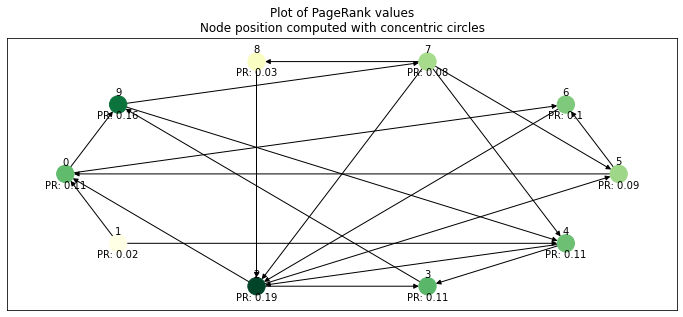

In [7]:
plot_graph(g, layout="shell")

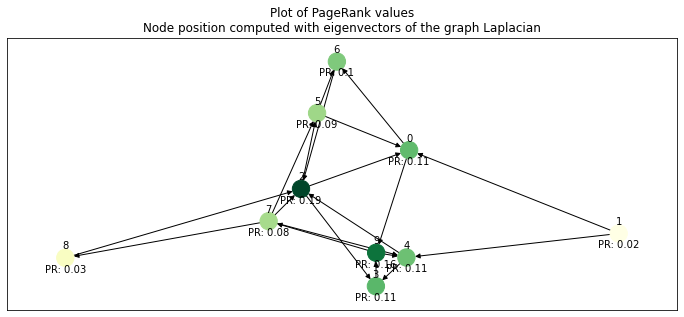

In [8]:
plot_graph(g, layout="spectral")

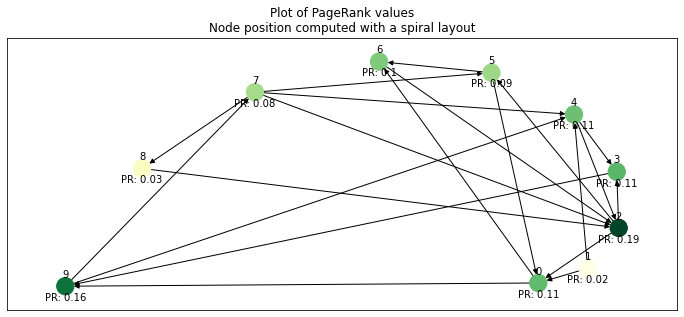

In [9]:
plot_graph(g, layout="spiral")

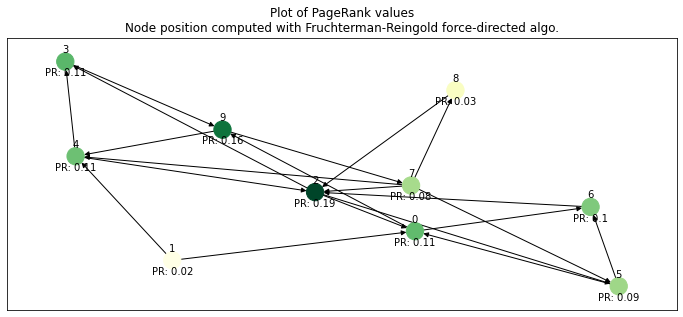

In [10]:
plot_graph(g, layout="spring")

### 2.2. Generating an Example Scale-Free Graph

In [11]:
g = generate_scale_free_graph(10)

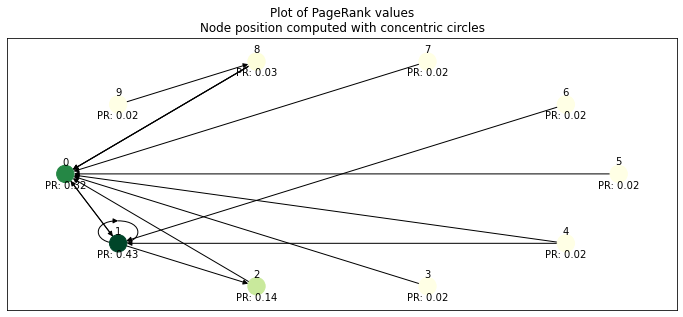

In [12]:
plot_graph(g, layout="shell")

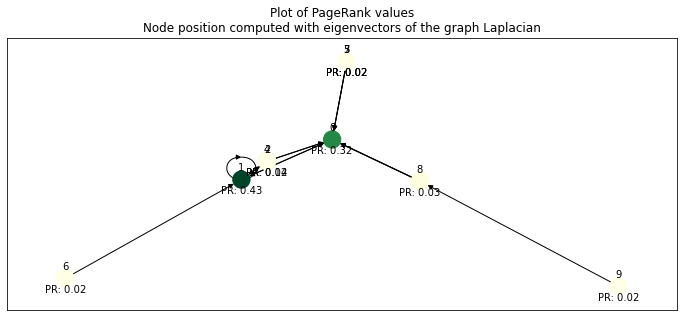

In [13]:
plot_graph(g, layout="spectral")

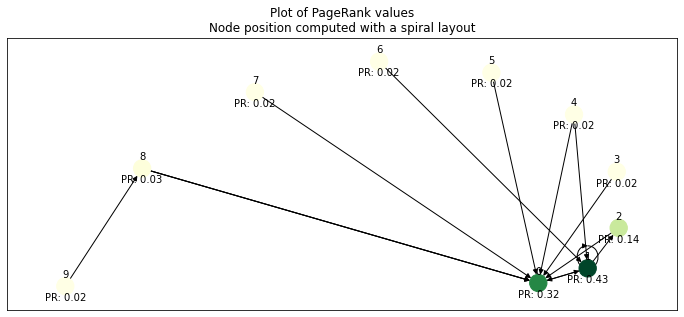

In [14]:
plot_graph(g, layout="spiral")

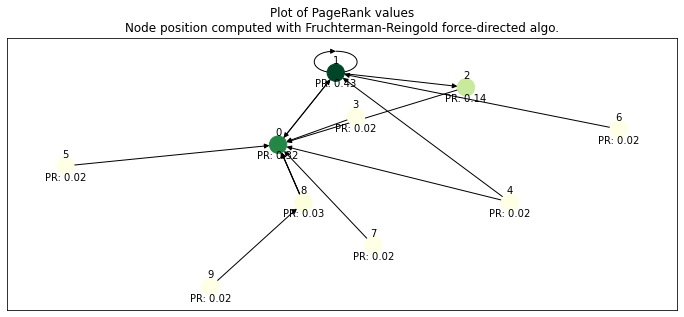

In [15]:
plot_graph(g, layout="spring")

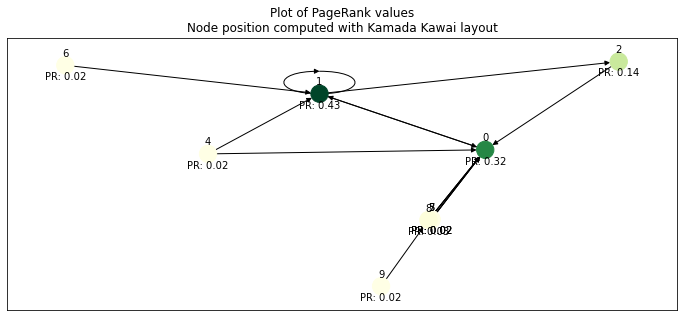

In [16]:
plot_graph(g, layout="kamada kawai")

### 2.2. Many Graphs Generation

#### Erdos' Method

The Erdős-Rényi graph or a binomial graph is a graph model that construct a graph $G_{n,p}$ where each of the possible edges between $n$ nodes appear with a fixed probability $p$. Each edge's probability of appearance is independent from the other edge's own probabilities.

> P. Erdős and A. Rényi, On Random Graphs, Publ. Math. 6, 290 (1959).

<u>Example</u>

In [17]:
erdos_generator = Random_Graph_Generator("erdos", True)
erdos_generator.graphs_generate(100, 5, 0.5)
erdos_generator.graphs_page_rank_compute()
eX, ey = erdos_generator.graphs_retrieve()

Erdos Graph Generator declared
5 graphs were generated
PageRank values computed


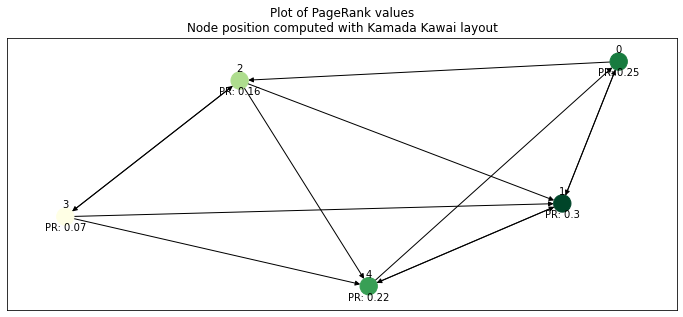

{0: 0.25009533652838356,
 1: 0.2962301103816566,
 2: 0.15742852824102532,
 3: 0.07460475374876574,
 4: 0.22164127110016882}

In [18]:
plot_graph(eX[50])
ey[50]

#### Scale-Free Method

The Scale-Free graph is a graph model that construct a graph $G_{n}$ of $n$ nodes with the property that the number of links $k$ originating from a given node exhibits a power law distribution $P(k)\sim k^(-\gamma)$. 

A scale-free network can be constructed by progressively adding nodes to an existing network and introducing links to existing nodes with preferential attachment so that the probability of linking to a given node $i$ is proportional to the number of existing links $k_i$ that node has such that:

$$P(\text{linking to node }i)\sim\frac{k_i}{\sum_jk_j}$$

> B. Bollobás, C. Borgs, J. Chayes, and O. Riordan, Directed scale-free graphs, Proceedings of the fourteenth annual ACM-SIAM Symposium on Discrete Algorithms, 132--139, 2003.

<u>Example</u>

In [19]:
scalefree_generator = Random_Graph_Generator("scale-free", True)
scalefree_generator.graphs_generate(100, 5)
scalefree_generator.graphs_page_rank_compute()
sfX, sfy = scalefree_generator.graphs_retrieve()

Scale-Free Graph Generator declared
5 graphs were generated
PageRank values computed


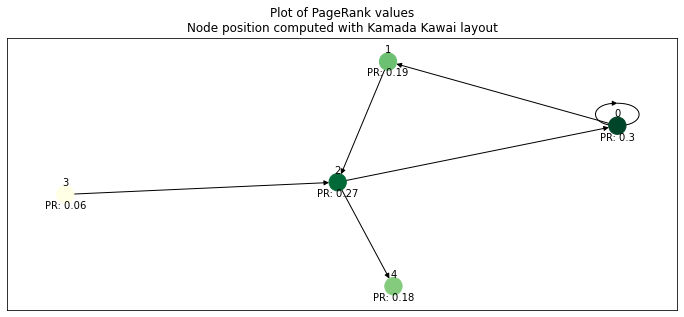

{0: 0.3045374270667082,
 1: 0.18919638877002912,
 2: 0.2713883169201675,
 3: 0.05976841447320817,
 4: 0.1751094527698872}

In [20]:
plot_graph(sfX[50])
sfy[50]

## 3. Learning PageRank

### 3.1. Building a Dataset
    
<u>Parameter selection</u>

To construct a dataset, we select:

- A **range of nodes $N$** to modulate the number of nodes in the graphs we want to create
- A selection of **graph-generating methods**. In our case: 
    - Erdos' method
    - Scale-Free method
- A **range of parameter values** for each parameter used to generate the graphs. In our case:
    - A range of probabilities $P$ to generate Erdos graphs
- A **number of graphs** to generate $n_{method}$ ***per given case and method***. In our case:
    - Erdos' method: we will obtain $n_{\text{erdos}}*len(P)*len(N)$
    - Scale-Free method: we will obtain $n_{\text{scale-free}}*len(N)$

As such, we choose to generate two graphs with either Erdos and Scale-Free graphs:

| Parameters | Description | Value | 
| :---: | :---: | :---: |
| P | Range of probabilities to generate Erdos graphs | {0.6} |
| N |  Range of nodes to generate graphs |  {60} |
| $n_{\text{erdos}}$ | Number of Erdos graphs to generate per case | 1 | 
| $n_{\text{scale-free}}$ | Number of Scale-Free graphs to generate per case | 2 |


In [21]:
# Declares the parameters

P            = [0.2]
N            = [15]
n_erdos      = 1
n_scale_free = 1

<u>Building the dataset</u>

We build 8 singular graphs each with a PageRank value per node, resulting in c. 70 nodes and 120 edges.

In [22]:
X, y = generate_graph_dataset(P, N, n_erdos, n_scale_free)

Generating Erdos graphs with parameters:
	Completed -- n=15, p=0.2

Generating Scale-Free graphs with parameter:
	Completed -- n=15


<u>Merging all graphs into a single entity and saving it</u>

We implement a function to concatenate all the generated graphs into a single large graph that can be used as input to a Graph Neural Network.

**Of note**, the cell is inactive on the assumption that it was already run and the result can be loaded using the load function located in the next cell.

In [12]:
pathX = "graph_files/graph_record02112022.graphml"
pathy = "graph_files/graph_record02112022_PageRanks.txt"

In [24]:
graphs, pageranks = concatenate_graph_dataset(X, y, pathX, pathy)

In [13]:
graphs, pageranks = load_concatenated_graph_dataset(pathX, pathy)

In [14]:
print(len(graphs.nodes), len(graphs.edges))

30 60


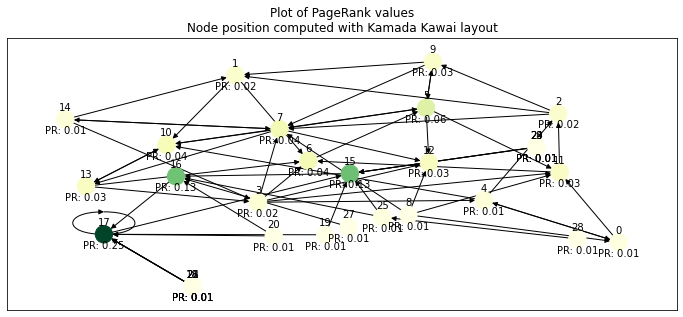

In [15]:
plot_graph(graphs)

<u>Building the DGL PageRank dataset</u>

In [16]:
dataset = PageRankDataset(graphs, pageranks, use_noise=True)
graph_noise_as_features = dataset[0]

dataset = PageRankDataset(graphs, pageranks, use_noise=False)
graph_torcheye_as_features = dataset[0]

### 3.2. Building Two Graph Neural Networks

<u>GNN with relaxation:</u>

In [17]:
# Declares important variables
graph  = graph_noise_as_features
E      = np.column_stack(graph.edges())
N      = graph.nodes()
labels = graph.ndata["label"].numpy()
train_mask = graph.ndata["train_mask"].numpy()
val_mask   = graph.ndata["test_mask"].numpy()
test_mask  = graph.ndata["val_mask"].numpy()

In [30]:
GNNrelaxation_model_adam = PageRankModelingWithRelaxationGNN(
    N, E, labels,
    train_mask, val_mask, test_mask,
    print_description = True
)


The model is a GNN based on a diffusion mechanism and relaxation.
A graph is processed by a set of nodes linked according to the
graph adjacency matrix/list of edges. The model updates the nodes' 
states by using an algorithm that shares information between 
(adjacent) nodes until an equilibrium state is reached. 

The output of the model is computed locally at each node based
on the node state.

The diffusion mechanism is constrained to ensure that a unique stable
equilibrium exists.

See also: https://persagen.com/files/misc/scarselli2009graph.pdf

Executing on device:  cpu


In [31]:
GNNrelaxation_model_adamw = PageRankModelingWithRelaxationGNN(
    N, E, labels,
    train_mask, val_mask, test_mask,
    optimizer = "AdamW"
)

Executing on device:  cpu


In [32]:
GNNrelaxation_model_adamax = PageRankModelingWithRelaxationGNN(
    N, E, labels,
    train_mask, val_mask, test_mask,
    optimizer = "Adamax"
)

Executing on device:  cpu


In [33]:
GNNrelaxation_model_adadelta = PageRankModelingWithRelaxationGNN(
    N, E, labels,
    train_mask, val_mask, test_mask,
    optimizer = "Adadelta"
)

Executing on device:  cpu


In [34]:
GNNrelaxation_model_SGD = PageRankModelingWithRelaxationGNN(
    N, E, labels,
    train_mask, val_mask, test_mask,
    optimizer = "SGD"
)

Executing on device:  cpu


<u>Convolutional GNN models (graph with noise as feature):</u>

In [35]:
# Declares important variables
hidden_features = 5
epochs = 1000

In [36]:
GCN_model_adam_noise = PageRankModelingWithGNN(
    graph_noise_as_features, 
    hidden_features, 
    epochs, 
    "GCN",
    print_description = True
)


The model was declared with GraphConv layers (2) which were introduced in:
> Semi-Supervised Classification with Graph Convolutional Networks
> by T. N. Kipf, M. Welling
> https://arxiv.org/pdf/1706.02216.pdf

Graph convolution is defined as follows:

```
h_i^{(l+1)} = \sigma(b^{(l)} + \sum_{j\in\mathcal{N}(i)}rac{1}{c_{ji}}h_j^{(l)}W^{(l)})
```

Where:
    - `\mathcal{N}(i)` is the set of neighbors of node `i`
    - `c_{ji}` is the product of the square root of node degrees
       `c_{ji} = \sqrt{|\mathcal{N}(j)|}\sqrt{|\mathcal{N}(i)|}`)
    - `\sigma` is an activation function.

See also: https://docs.dgl.ai/api/python/nn.pytorch.html#graphconv



In [37]:
GCN_model_adamw_noise = PageRankModelingWithGNN(
    graph_noise_as_features, 
    hidden_features, 
    epochs, 
    "GCN",
    optimizer = "AdamW"
)

In [38]:
GCN_model_adamax_noise = PageRankModelingWithGNN(
    graph_noise_as_features, 
    hidden_features, 
    epochs, 
    "GCN",
    optimizer = "Adamax"
)

In [39]:
GCN_model_adadelta_noise = PageRankModelingWithGNN(
    graph_noise_as_features, 
    hidden_features, 
    epochs, 
    "GCN",
    optimizer = "Adadelta"
)

In [40]:
GCN_model_SGD_noise = PageRankModelingWithGNN(
    graph_noise_as_features, 
    hidden_features, 
    epochs, 
    "GCN",
    optimizer = "SGD"
)

In [41]:
SAGE_model_adam_noise = PageRankModelingWithGNN(
    graph_noise_as_features, 
    hidden_features, 
    epochs, 
    "SAGE",
    print_description = True
)


The model was declared with GraphSAGE layers (2) which were introduced in:
> Inductive Representation Learning on Large Graphs
> by W.L. Hamiton, R. Ying, and J. Leskovec
> https://arxiv.org/pdf/1706.02216.pdf

The GraphSAGE Algorithm trains weight matrices instead of relying on 
embedding tables. It allows adding and removing nodes directly via the 
weight matrix. Nodes embeddings do not need to be recomputed.

```
egin{align}
    h_{\mathcal{N}(i)}^{(l+1)} &= 
        	ext{aggregate}
        \left(
            \{h_{j}^{l}, orall j \in \mathcal{N}(i) \}
ight) h_{i}^{(l+1)}
    \
    &= \sigma 
        \left(
            W \cdot \mathrm{concat} (h_{i}^{l}, h_{\mathcal{N}(i)}^{l+1}) 
ight) h_{i}^{(l+1)} \
    &= \mathrm{norm}(h_{i}^{l})
\end{align}
```

See also: https://docs.dgl.ai/api/python/nn.pytorch.html#sageconv



In [42]:
SAGE_model_adamw_noise = PageRankModelingWithGNN(
    graph_noise_as_features, 
    hidden_features, 
    epochs, 
    "SAGE",
    optimizer = "AdamW"
)

In [43]:
SAGE_model_adamax_noise = PageRankModelingWithGNN(
    graph_noise_as_features, 
    hidden_features, 
    epochs, 
    "SAGE",
    optimizer = "Adamax"
)

In [44]:
SAGE_model_adadelta_noise = PageRankModelingWithGNN(
    graph_noise_as_features, 
    hidden_features, 
    epochs, 
    "SAGE",
    optimizer = "Adadelta"
)

In [45]:
SAGE_model_SGD_noise = PageRankModelingWithGNN(
    graph_noise_as_features, 
    hidden_features, 
    epochs, 
    "SAGE",
    optimizer = "SGD"
)

<u>Convolutional GNN models (graph with torcheye as feature):</u>

In [46]:
# Declares important variables
hidden_features = 5
epochs = 1000

In [47]:
GCN_model_adam_eye = PageRankModelingWithGNN(
    graph_torcheye_as_features, 
    hidden_features, 
    epochs, 
    "GCN",
    print_description = True
)


The model was declared with GraphConv layers (2) which were introduced in:
> Semi-Supervised Classification with Graph Convolutional Networks
> by T. N. Kipf, M. Welling
> https://arxiv.org/pdf/1706.02216.pdf

Graph convolution is defined as follows:

```
h_i^{(l+1)} = \sigma(b^{(l)} + \sum_{j\in\mathcal{N}(i)}rac{1}{c_{ji}}h_j^{(l)}W^{(l)})
```

Where:
    - `\mathcal{N}(i)` is the set of neighbors of node `i`
    - `c_{ji}` is the product of the square root of node degrees
       `c_{ji} = \sqrt{|\mathcal{N}(j)|}\sqrt{|\mathcal{N}(i)|}`)
    - `\sigma` is an activation function.

See also: https://docs.dgl.ai/api/python/nn.pytorch.html#graphconv



In [48]:
GCN_model_adamw_eye = PageRankModelingWithGNN(
    graph_torcheye_as_features, 
    hidden_features, 
    epochs, 
    "GCN",
    optimizer = "AdamW"
)

In [49]:
GCN_model_adamax_eye = PageRankModelingWithGNN(
    graph_torcheye_as_features, 
    hidden_features, 
    epochs, 
    "GCN",
    optimizer = "Adamax"
)

In [50]:
GCN_model_adadelta_eye = PageRankModelingWithGNN(
    graph_torcheye_as_features, 
    hidden_features, 
    epochs, 
    "GCN",
    optimizer = "Adadelta"
)

In [51]:
GCN_model_SGD_eye = PageRankModelingWithGNN(
    graph_torcheye_as_features, 
    hidden_features, 
    epochs, 
    "GCN",
    optimizer = "SGD"
)

In [52]:
SAGE_model_adam_eye = PageRankModelingWithGNN(
    graph_torcheye_as_features, 
    hidden_features, 
    epochs, 
    "SAGE",
    print_description = True
)


The model was declared with GraphSAGE layers (2) which were introduced in:
> Inductive Representation Learning on Large Graphs
> by W.L. Hamiton, R. Ying, and J. Leskovec
> https://arxiv.org/pdf/1706.02216.pdf

The GraphSAGE Algorithm trains weight matrices instead of relying on 
embedding tables. It allows adding and removing nodes directly via the 
weight matrix. Nodes embeddings do not need to be recomputed.

```
egin{align}
    h_{\mathcal{N}(i)}^{(l+1)} &= 
        	ext{aggregate}
        \left(
            \{h_{j}^{l}, orall j \in \mathcal{N}(i) \}
ight) h_{i}^{(l+1)}
    \
    &= \sigma 
        \left(
            W \cdot \mathrm{concat} (h_{i}^{l}, h_{\mathcal{N}(i)}^{l+1}) 
ight) h_{i}^{(l+1)} \
    &= \mathrm{norm}(h_{i}^{l})
\end{align}
```

See also: https://docs.dgl.ai/api/python/nn.pytorch.html#sageconv



In [53]:
SAGE_model_adamw_eye = PageRankModelingWithGNN(
    graph_torcheye_as_features, 
    hidden_features, 
    epochs, 
    "SAGE",
    optimizer = "AdamW"
)

In [54]:
SAGE_model_adamax_eye = PageRankModelingWithGNN(
    graph_torcheye_as_features, 
    hidden_features, 
    epochs, 
    "SAGE",
    optimizer = "Adamax"
)

In [55]:
SAGE_model_adadelta_eye = PageRankModelingWithGNN(
    graph_torcheye_as_features, 
    hidden_features, 
    epochs, 
    "SAGE",
    optimizer = "Adadelta"
)

In [56]:
SAGE_model_SGD_eye = PageRankModelingWithGNN(
    graph_torcheye_as_features, 
    hidden_features, 
    epochs, 
    "SAGE",
    optimizer = "SGD"
)

### 3.3. Training the Graph Neural Networks

<u>GNN with relaxation (graph with noise as feature):</u>

Epoch -- 100
	Training -- Mean Loss: 0.0186, Iterations: 5
	Validation -- Mean Loss: 0.0117, Iterations: 5
Epoch -- 200
	Training -- Mean Loss: 0.0109, Iterations: 5
	Validation -- Mean Loss: 0.0042, Iterations: 5
Epoch -- 300
	Training -- Mean Loss: 0.0058, Iterations: 5
	Validation -- Mean Loss: 0.0025, Iterations: 5
Epoch -- 400
	Training -- Mean Loss: 0.0032, Iterations: 5
	Validation -- Mean Loss: 0.0024, Iterations: 5
Epoch -- 500
	Training -- Mean Loss: 0.0014, Iterations: 5
	Validation -- Mean Loss: 0.0029, Iterations: 5
Epoch -- 600
	Training -- Mean Loss: 0.0005, Iterations: 6
	Validation -- Mean Loss: 0.0042, Iterations: 6
Epoch -- 700
	Training -- Mean Loss: 0.0002, Iterations: 6
	Validation -- Mean Loss: 0.0057, Iterations: 6
Epoch -- 800
	Training -- Mean Loss: 1e-04, Iterations: 7
	Validation -- Mean Loss: 0.0066, Iterations: 7
Epoch -- 900
	Training -- Mean Loss: 1e-04, Iterations: 8
	Validation -- Mean Loss: 0.0071, Iterations: 8
Epoch -- 1000
	Training -- Mean Loss: 0

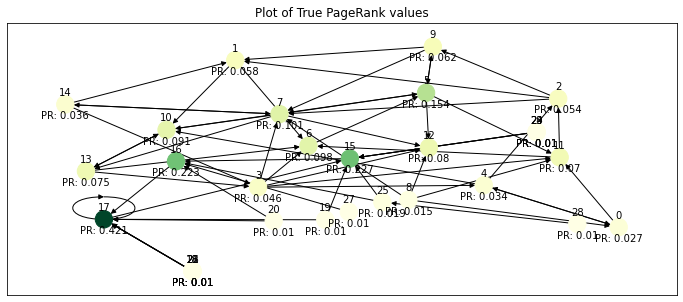

Plot with predicted labels
--------------------------


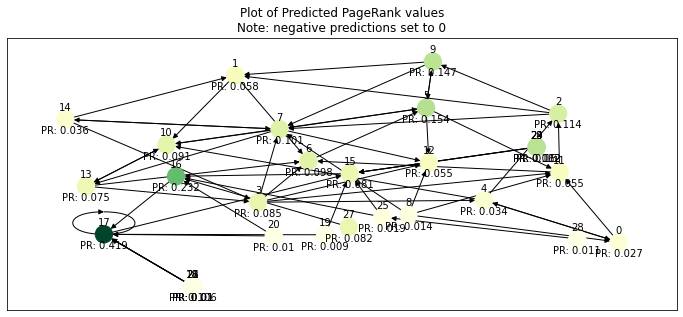

In [57]:
GNNrelaxation_model_adam.run(
    print_node_results=True, 
    print_graph_results=True
)

Epoch -- 100
	Training -- Mean Loss: 0.0054, Iterations: 5
	Validation -- Mean Loss: 0.0019, Iterations: 5
Epoch -- 200
	Training -- Mean Loss: 0.0004, Iterations: 5
	Validation -- Mean Loss: 0.0043, Iterations: 5
Epoch -- 300
	Training -- Mean Loss: 0.0, Iterations: 5
	Validation -- Mean Loss: 0.0056, Iterations: 5
Epoch -- 400
	Training -- Mean Loss: 0.0, Iterations: 6
	Validation -- Mean Loss: 0.0059, Iterations: 6
Epoch -- 500
	Training -- Mean Loss: 0.0, Iterations: 6
	Validation -- Mean Loss: 0.0059, Iterations: 6
Epoch -- 600
	Training -- Mean Loss: 0.0, Iterations: 6
	Validation -- Mean Loss: 0.006, Iterations: 6
Epoch -- 700
	Training -- Mean Loss: 0.0, Iterations: 6
	Validation -- Mean Loss: 0.006, Iterations: 6
Epoch -- 800
	Training -- Mean Loss: 0.0, Iterations: 6
	Validation -- Mean Loss: 0.006, Iterations: 6
Epoch -- 900
	Training -- Mean Loss: 0.0, Iterations: 5
	Validation -- Mean Loss: 0.006, Iterations: 5
Epoch -- 1000
	Training -- Mean Loss: 0.0, Iterations: 5
	Vali

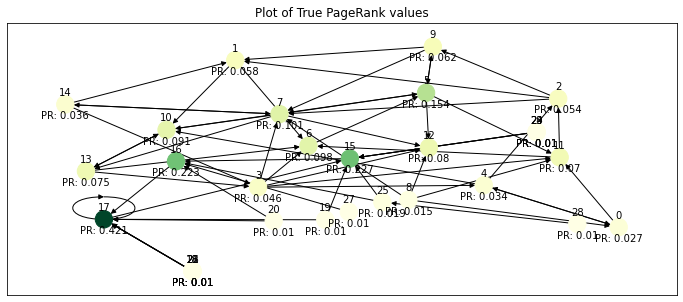

Plot with predicted labels
--------------------------


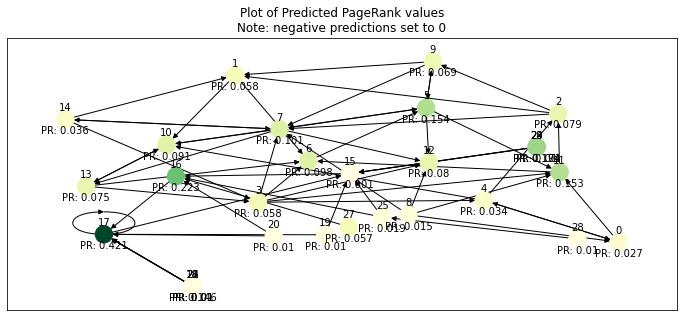

In [58]:
GNNrelaxation_model_adamw.run(
    print_node_results=True, 
    print_graph_results=True
)

Epoch -- 100
	Training -- Mean Loss: 0.0836, Iterations: 5
	Validation -- Mean Loss: 0.0516, Iterations: 5
Epoch -- 200
	Training -- Mean Loss: 0.0209, Iterations: 5
	Validation -- Mean Loss: 0.0042, Iterations: 5
Epoch -- 300
	Training -- Mean Loss: 0.0144, Iterations: 5
	Validation -- Mean Loss: 0.0022, Iterations: 5
Epoch -- 400
	Training -- Mean Loss: 0.0136, Iterations: 5
	Validation -- Mean Loss: 0.0026, Iterations: 5
Epoch -- 500
	Training -- Mean Loss: 0.0133, Iterations: 5
	Validation -- Mean Loss: 0.0025, Iterations: 5
Epoch -- 600
	Training -- Mean Loss: 0.013, Iterations: 5
	Validation -- Mean Loss: 0.0023, Iterations: 5
Epoch -- 700
	Training -- Mean Loss: 0.0127, Iterations: 5
	Validation -- Mean Loss: 0.0021, Iterations: 5
Epoch -- 800
	Training -- Mean Loss: 0.0125, Iterations: 5
	Validation -- Mean Loss: 0.0019, Iterations: 5
Epoch -- 900
	Training -- Mean Loss: 0.0122, Iterations: 5
	Validation -- Mean Loss: 0.0017, Iterations: 5
Epoch -- 1000
	Training -- Mean Loss: 

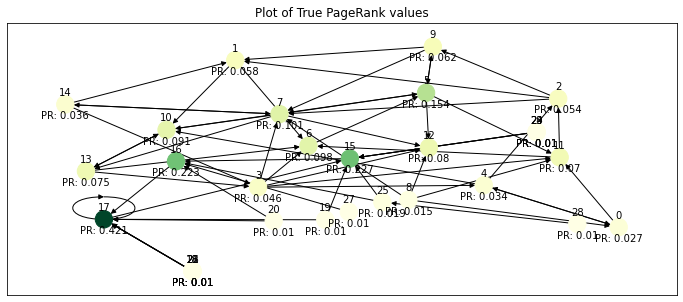

Plot with predicted labels
--------------------------


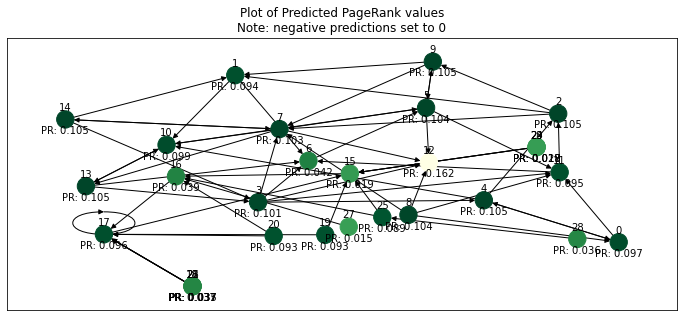

In [59]:
GNNrelaxation_model_adamax.run(
    print_node_results=True, 
    print_graph_results=True
)

Epoch -- 100
	Training -- Mean Loss: 0.234, Iterations: 4
	Validation -- Mean Loss: 0.2043, Iterations: 4
Epoch -- 200
	Training -- Mean Loss: 0.2318, Iterations: 4
	Validation -- Mean Loss: 0.202, Iterations: 4
Epoch -- 300
	Training -- Mean Loss: 0.2292, Iterations: 4
	Validation -- Mean Loss: 0.1994, Iterations: 4
Epoch -- 400
	Training -- Mean Loss: 0.2264, Iterations: 4
	Validation -- Mean Loss: 0.1965, Iterations: 4
Epoch -- 500
	Training -- Mean Loss: 0.2233, Iterations: 4
	Validation -- Mean Loss: 0.1934, Iterations: 4
Epoch -- 600
	Training -- Mean Loss: 0.2199, Iterations: 4
	Validation -- Mean Loss: 0.1901, Iterations: 4
Epoch -- 700
	Training -- Mean Loss: 0.2165, Iterations: 4
	Validation -- Mean Loss: 0.1866, Iterations: 4
Epoch -- 800
	Training -- Mean Loss: 0.2128, Iterations: 4
	Validation -- Mean Loss: 0.1829, Iterations: 4
Epoch -- 900
	Training -- Mean Loss: 0.209, Iterations: 4
	Validation -- Mean Loss: 0.1791, Iterations: 4
Epoch -- 1000
	Training -- Mean Loss: 0.

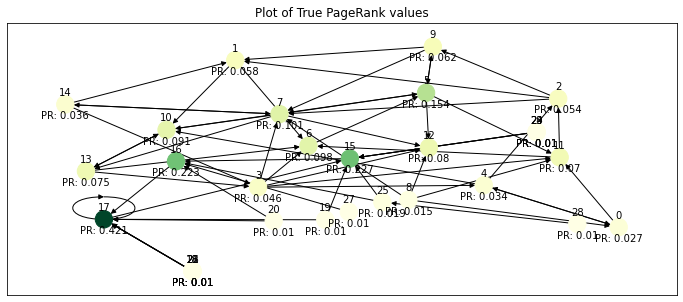

Plot with predicted labels
--------------------------


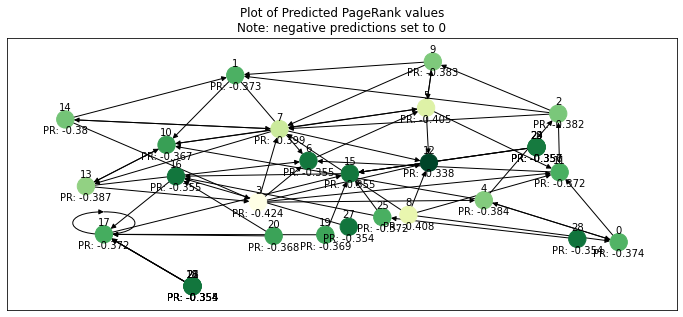

In [60]:
GNNrelaxation_model_adadelta.run(
    print_node_results=True, 
    print_graph_results=True
)

Epoch -- 100
	Training -- Mean Loss: 0.0959, Iterations: 4
	Validation -- Mean Loss: 0.0696, Iterations: 4
Epoch -- 200
	Training -- Mean Loss: 0.0417, Iterations: 4
	Validation -- Mean Loss: 0.0221, Iterations: 4
Epoch -- 300
	Training -- Mean Loss: 0.0214, Iterations: 4
	Validation -- Mean Loss: 0.0063, Iterations: 4
Epoch -- 400
	Training -- Mean Loss: 0.0138, Iterations: 4
	Validation -- Mean Loss: 0.0015, Iterations: 4
Epoch -- 500
	Training -- Mean Loss: 0.0109, Iterations: 4
	Validation -- Mean Loss: 0.0005, Iterations: 4
Epoch -- 600
	Training -- Mean Loss: 0.0098, Iterations: 4
	Validation -- Mean Loss: 0.0005, Iterations: 4
Epoch -- 700
	Training -- Mean Loss: 0.0094, Iterations: 4
	Validation -- Mean Loss: 0.0008, Iterations: 4
Epoch -- 800
	Training -- Mean Loss: 0.0093, Iterations: 4
	Validation -- Mean Loss: 0.0011, Iterations: 4
Epoch -- 900
	Training -- Mean Loss: 0.0092, Iterations: 4
	Validation -- Mean Loss: 0.0013, Iterations: 4
Epoch -- 1000
	Training -- Mean Loss:

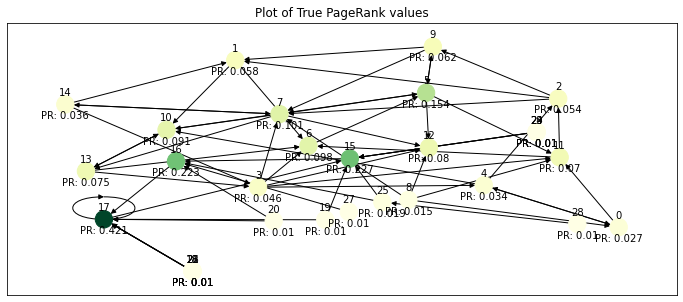

Plot with predicted labels
--------------------------


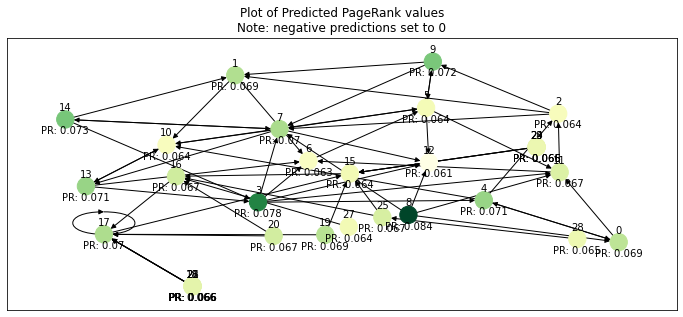

In [61]:
GNNrelaxation_model_SGD.run(
    print_node_results=True, 
    print_graph_results=True
)

<u>Convolutional GNN models (graph with noise as feature):</u>

Epoch 0,	loss: 0.09541;		val loss 0.015397
Epoch 50,	loss: 0.015351;		val loss 0.00267
Epoch 100,	loss: 0.009397;		val loss 0.001659
Epoch 150,	loss: 0.003801;		val loss 0.000443
#### VALIDATION LOSS NO IMPROVEMENT IN 10 EPOCHS ####
#### EARLY STOPPING, epoch: 190             ####
Final train loss: 0.002825, validation loss: 0.00036301027284935117.
Test loss: 0.000223


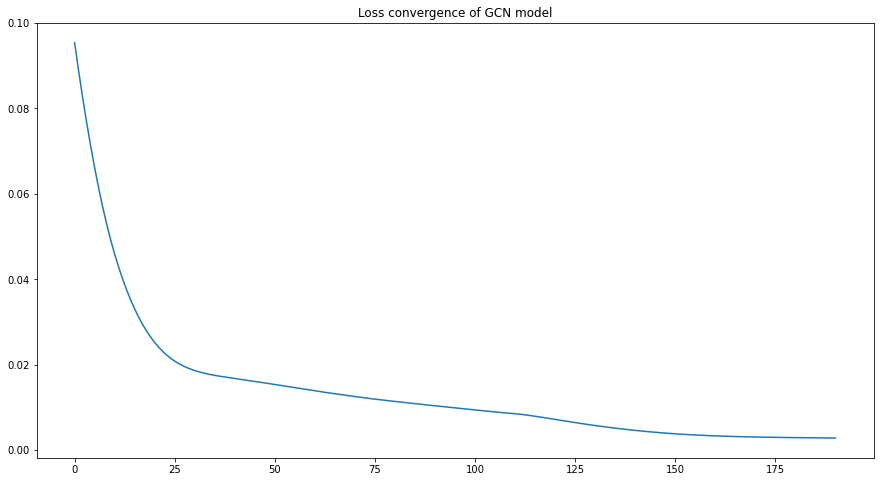



Plot with true labels
---------------------


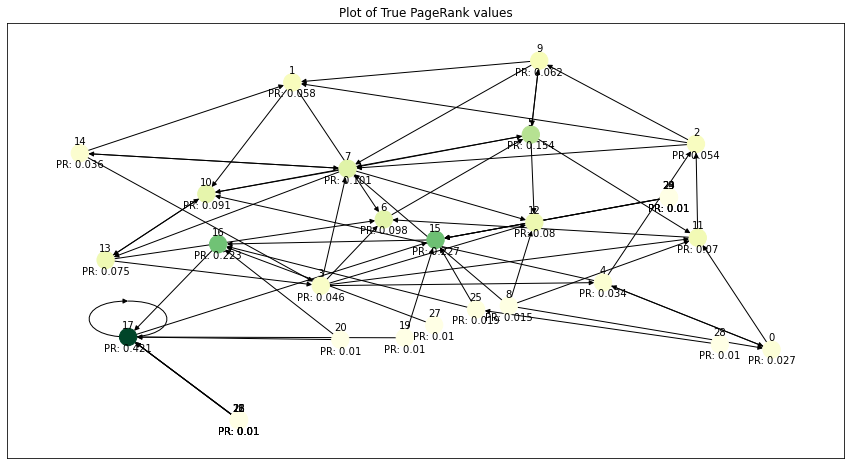

Plot with predicted labels
--------------------------


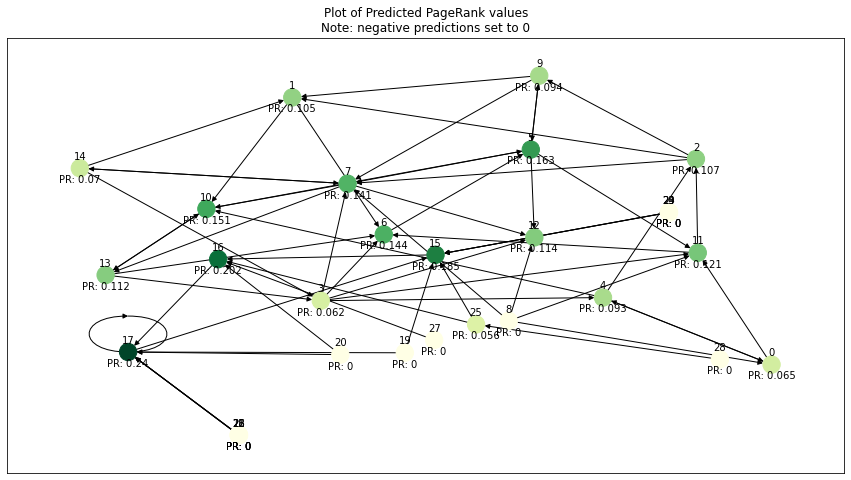

In [62]:
GCN_model_adam_noise.run(print_graph_results=True)

Epoch 0,	loss: 0.005018;		val loss 0.001236
#### VALIDATION LOSS NO IMPROVEMENT IN 10 EPOCHS ####
#### EARLY STOPPING, epoch: 21             ####
Final train loss: 0.003609, validation loss: 0.0011328475084155798.
Test loss: 0.000172


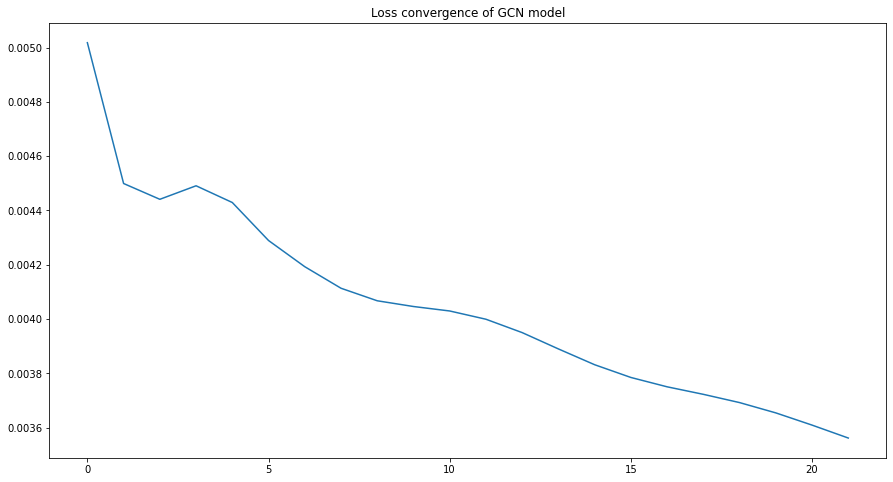



Plot with true labels
---------------------


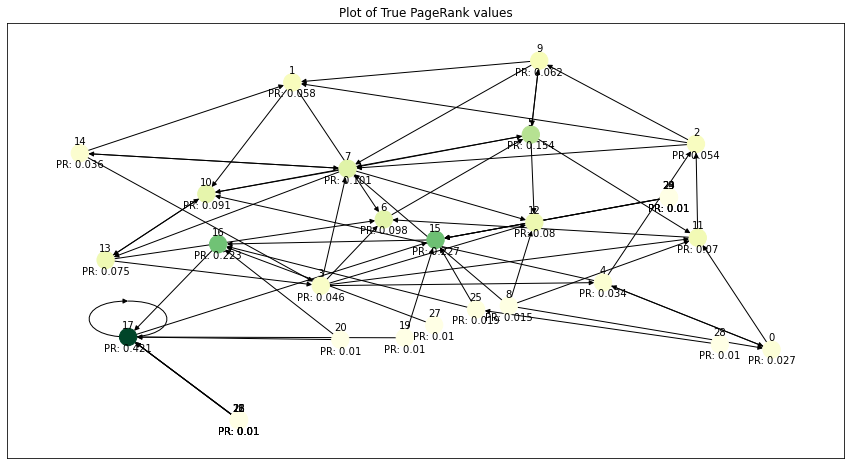

Plot with predicted labels
--------------------------


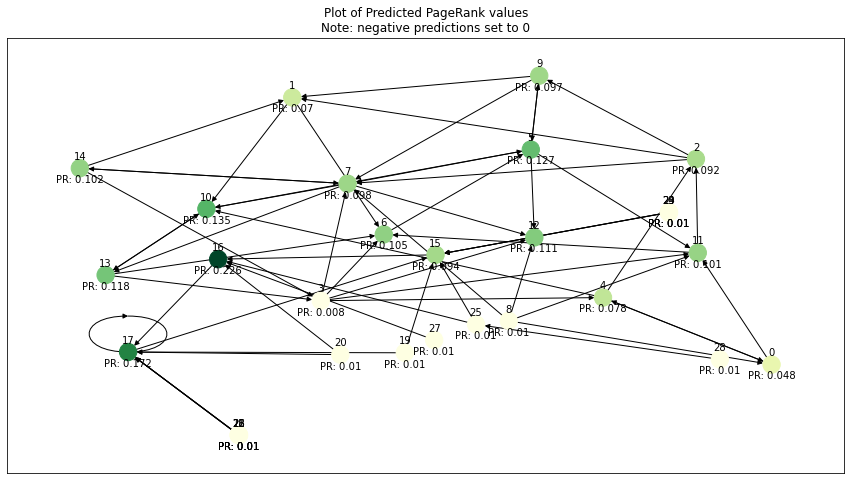

In [63]:
GCN_model_adamw_noise.run(print_graph_results=True)

Epoch 0,	loss: 0.066215;		val loss 0.006183
#### VALIDATION LOSS NO IMPROVEMENT IN 10 EPOCHS ####
#### EARLY STOPPING, epoch: 22             ####
Final train loss: 0.007675, validation loss: 0.0026326749939471483.
Test loss: 0.001191


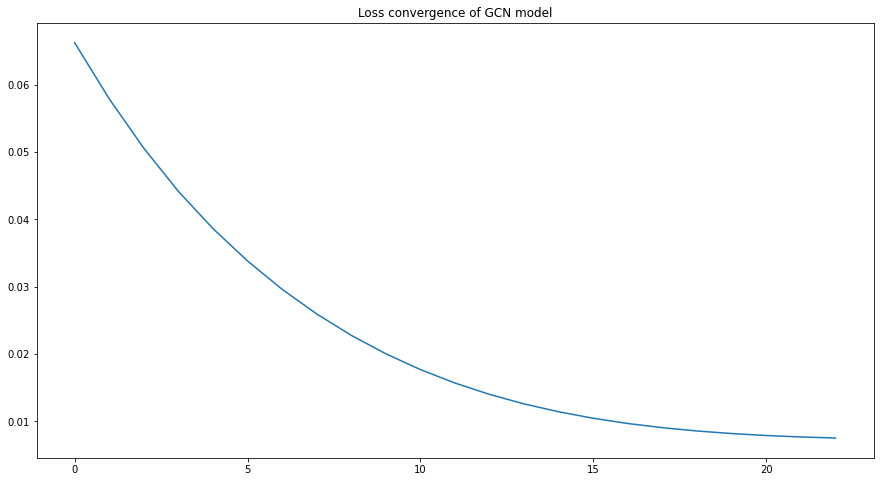



Plot with true labels
---------------------


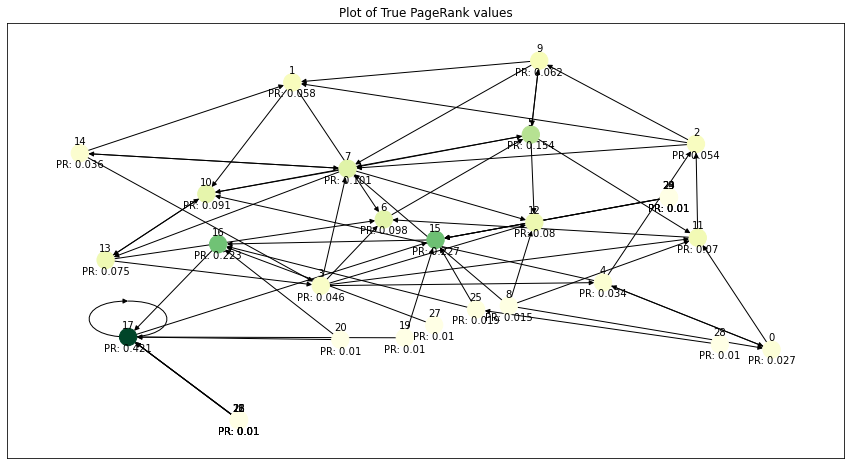

Plot with predicted labels
--------------------------


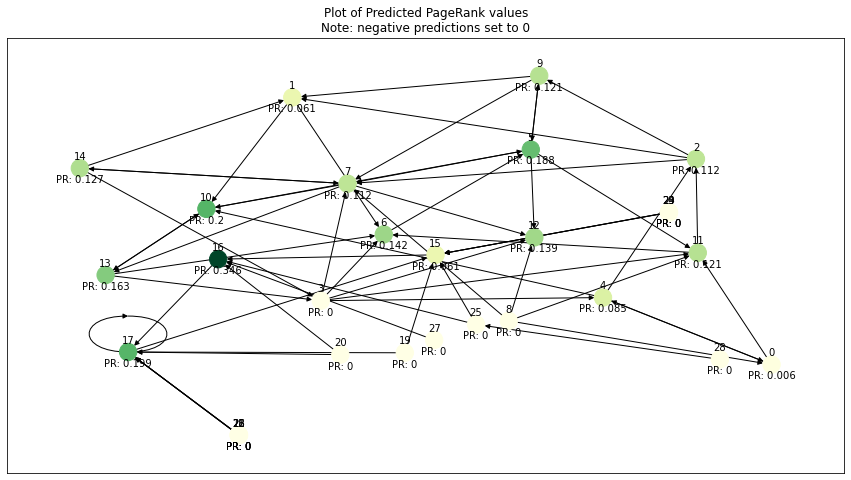

In [64]:
GCN_model_adamax_noise.run(print_graph_results=True)

Epoch 0,	loss: 0.100291;		val loss 0.017276
Epoch 50,	loss: 0.097885;		val loss 0.016823
Epoch 100,	loss: 0.095152;		val loss 0.01631
Epoch 150,	loss: 0.09218;		val loss 0.015754
Epoch 200,	loss: 0.089021;		val loss 0.015164
Epoch 250,	loss: 0.085719;		val loss 0.014548
Epoch 300,	loss: 0.082309;		val loss 0.013913
Epoch 350,	loss: 0.078824;		val loss 0.013265
Epoch 400,	loss: 0.075292;		val loss 0.012608
Epoch 450,	loss: 0.071738;		val loss 0.011948
Epoch 500,	loss: 0.068185;		val loss 0.011289
Epoch 550,	loss: 0.064654;		val loss 0.010634
Epoch 600,	loss: 0.061161;		val loss 0.009988
Epoch 650,	loss: 0.057725;		val loss 0.009352
Epoch 700,	loss: 0.054358;		val loss 0.008731
Epoch 750,	loss: 0.051074;		val loss 0.008126
Epoch 800,	loss: 0.047884;		val loss 0.007539
Epoch 850,	loss: 0.044798;		val loss 0.006972
Epoch 900,	loss: 0.041824;		val loss 0.006427
Epoch 950,	loss: 0.03897;		val loss 0.005906
Final train loss: 0.036294, validation loss: 0.005418.
Test loss: 0.00152


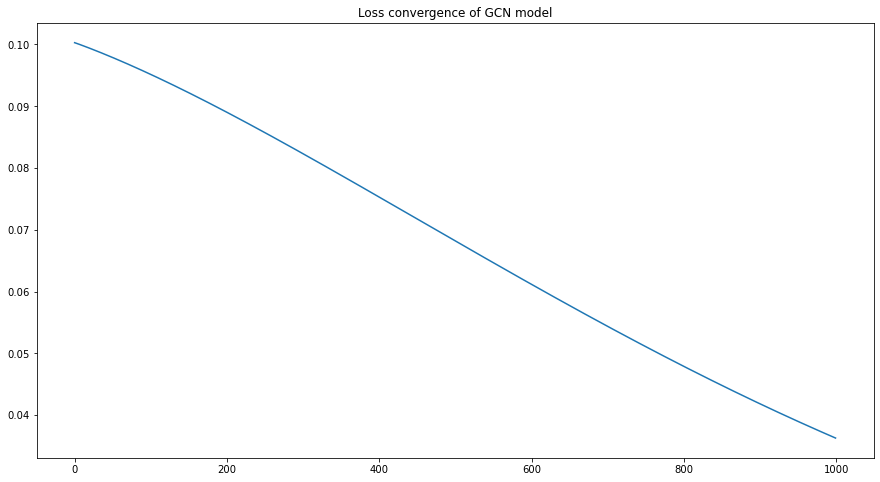



Plot with true labels
---------------------


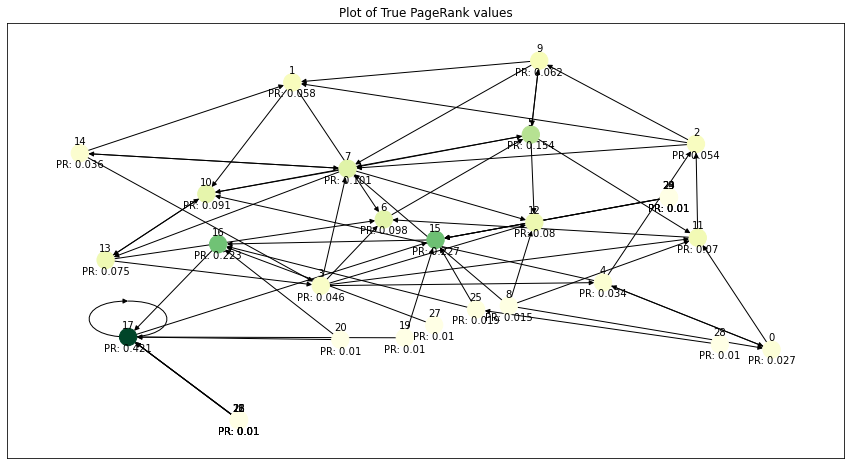

Plot with predicted labels
--------------------------


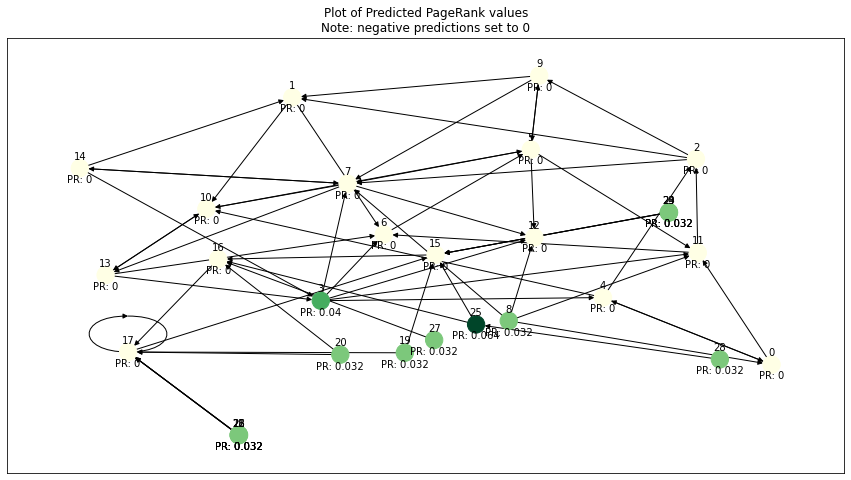

In [65]:
GCN_model_adadelta_noise.run(print_graph_results=True)

Epoch 0,	loss: 0.006353;		val loss 0.0019
Epoch 50,	loss: 0.004171;		val loss 0.000978
Epoch 100,	loss: 0.003619;		val loss 0.000699
Epoch 150,	loss: 0.003388;		val loss 0.000583
Epoch 200,	loss: 0.003242;		val loss 0.000522
Epoch 250,	loss: 0.003133;		val loss 0.000484
Epoch 300,	loss: 0.003049;		val loss 0.000458
Epoch 350,	loss: 0.002982;		val loss 0.000439
Epoch 400,	loss: 0.002928;		val loss 0.000425
Epoch 450,	loss: 0.002884;		val loss 0.000414
Epoch 500,	loss: 0.002848;		val loss 0.000405
Epoch 550,	loss: 0.002818;		val loss 0.000398
Epoch 600,	loss: 0.002792;		val loss 0.000393
Epoch 650,	loss: 0.00277;		val loss 0.000388
Epoch 700,	loss: 0.002751;		val loss 0.000384
Epoch 750,	loss: 0.002734;		val loss 0.00038
Epoch 800,	loss: 0.002718;		val loss 0.000376
Epoch 850,	loss: 0.002703;		val loss 0.000373
Epoch 900,	loss: 0.00269;		val loss 0.00037
Epoch 950,	loss: 0.002677;		val loss 0.000367
Final train loss: 0.002666, validation loss: 0.000364.
Test loss: 0.000215


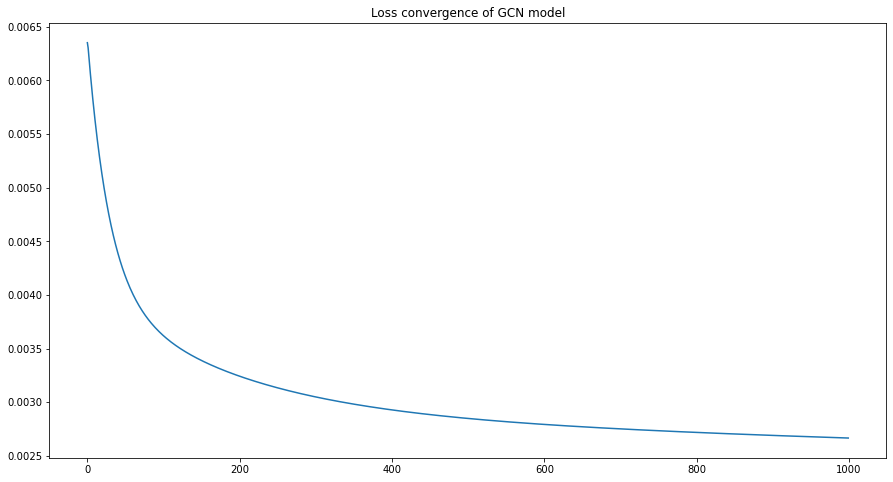



Plot with true labels
---------------------


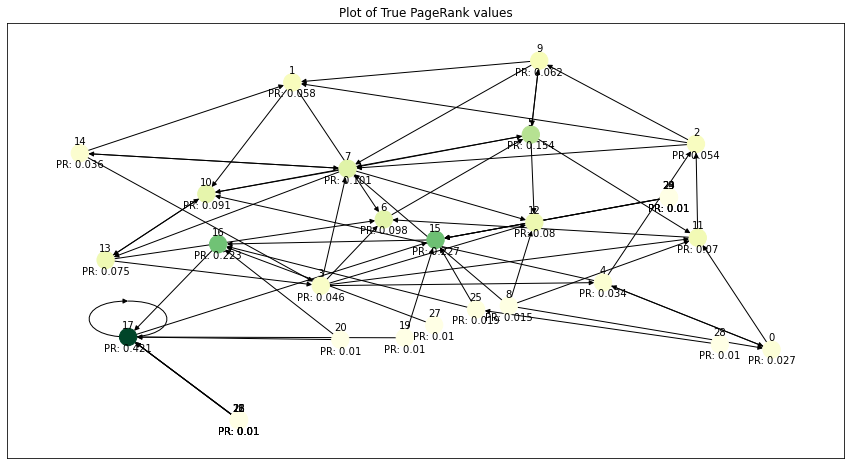

Plot with predicted labels
--------------------------


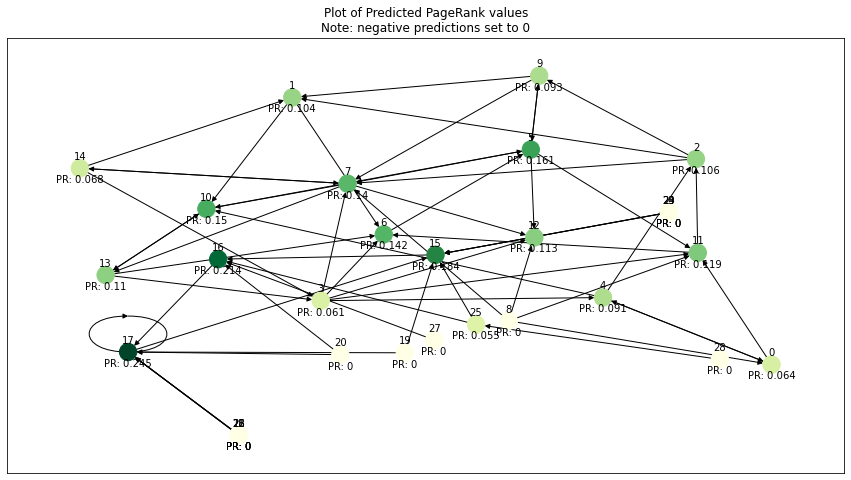

In [66]:
GCN_model_SGD_noise.run(print_graph_results=True)

Epoch 0,	loss: 0.059121;		val loss 0.005072
#### VALIDATION LOSS NO IMPROVEMENT IN 10 EPOCHS ####
#### EARLY STOPPING, epoch: 23             ####
Final train loss: 0.017797, validation loss: 0.0011271319817751646.
Test loss: 0.001837


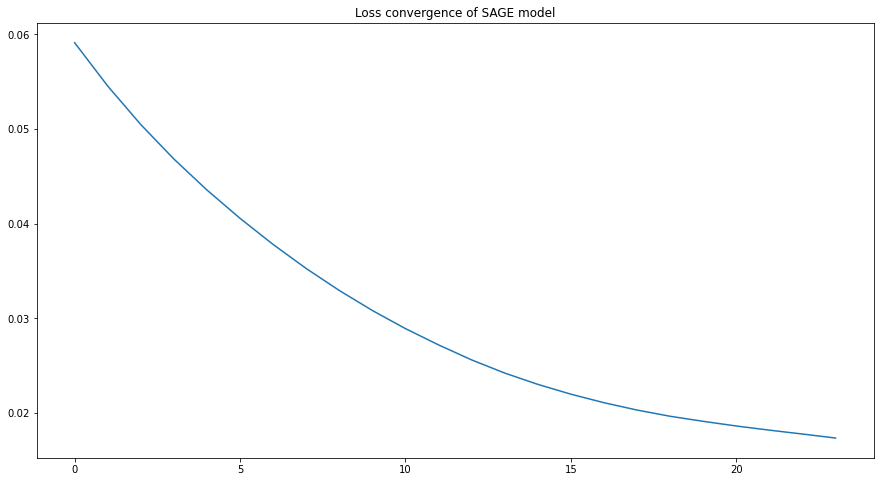



Plot with true labels
---------------------


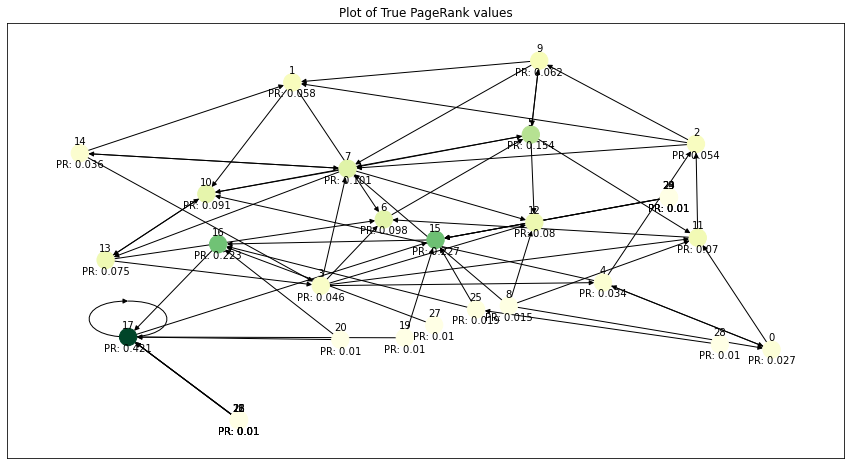

Plot with predicted labels
--------------------------


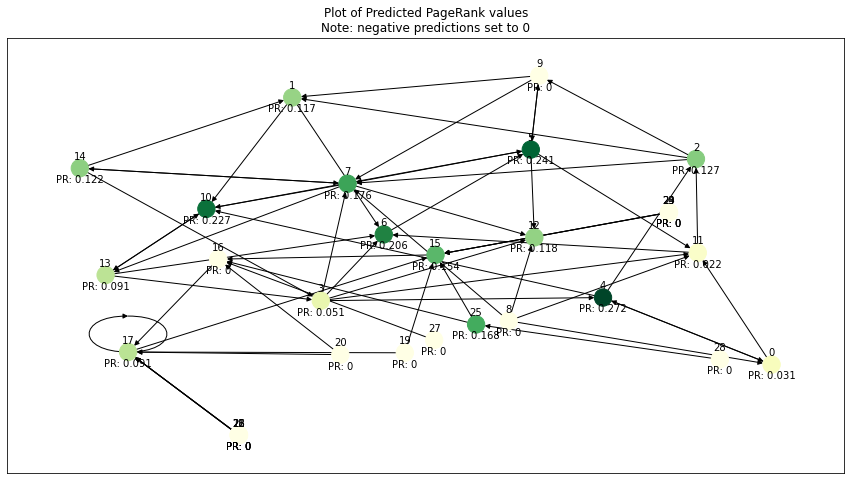

In [67]:
SAGE_model_adam_noise.run(print_graph_results=True)

Epoch 0,	loss: 0.070157;		val loss 0.005027
#### VALIDATION LOSS NO IMPROVEMENT IN 10 EPOCHS ####
#### EARLY STOPPING, epoch: 10             ####
Final train loss: 0.047325, validation loss: 0.006727571599185467.
Test loss: 0.017011


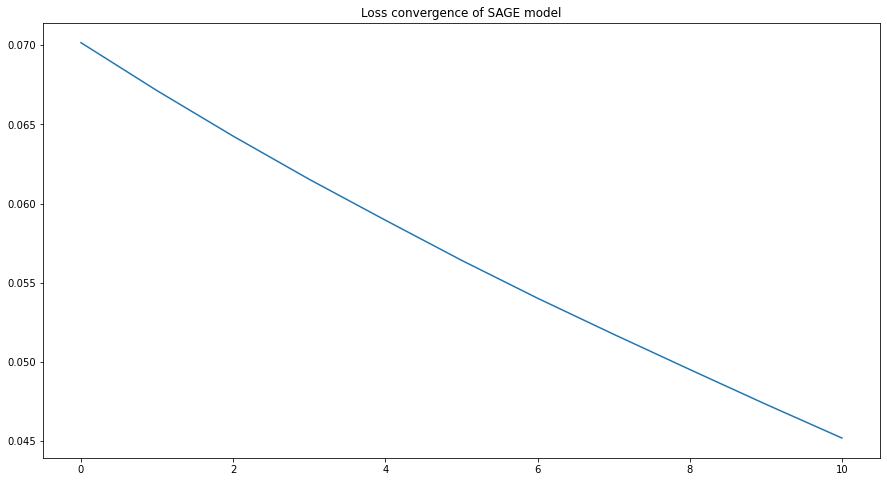



Plot with true labels
---------------------


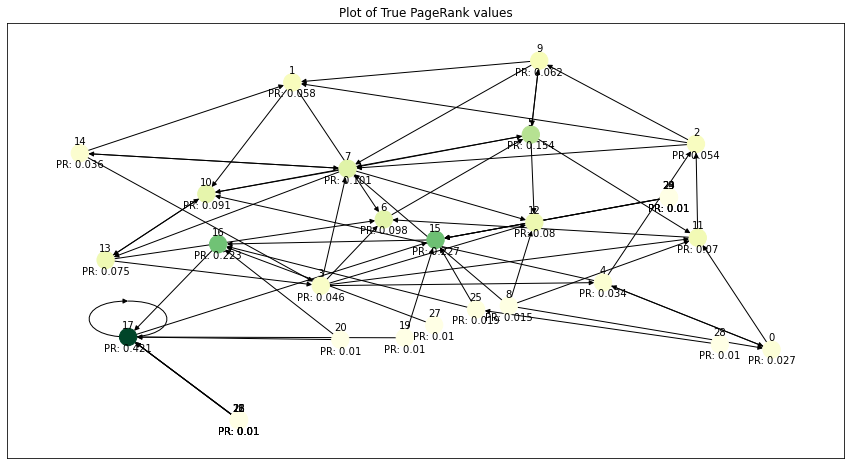

Plot with predicted labels
--------------------------


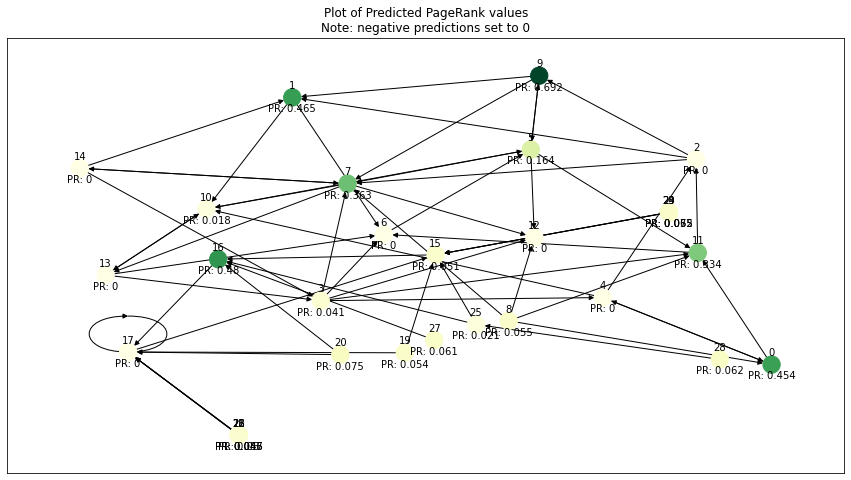

In [68]:
SAGE_model_adamw_noise.run(print_graph_results=True)

Epoch 0,	loss: 1.083189;		val loss 0.26592
Epoch 50,	loss: 0.111974;		val loss 0.037713
Epoch 100,	loss: 0.09438;		val loss 0.028851
Epoch 150,	loss: 0.080471;		val loss 0.022853
Epoch 200,	loss: 0.06876;		val loss 0.017814
Epoch 250,	loss: 0.058541;		val loss 0.013623
Epoch 300,	loss: 0.049991;		val loss 0.01033
Epoch 350,	loss: 0.042906;		val loss 0.007795
Epoch 400,	loss: 0.036977;		val loss 0.005835
Epoch 450,	loss: 0.031982;		val loss 0.004319
Epoch 500,	loss: 0.027766;		val loss 0.003155
Epoch 550,	loss: 0.024226;		val loss 0.002266
Epoch 600,	loss: 0.021263;		val loss 0.001603
Epoch 650,	loss: 0.018784;		val loss 0.001114
Epoch 700,	loss: 0.016717;		val loss 0.00076
Epoch 750,	loss: 0.014974;		val loss 0.000508
Epoch 800,	loss: 0.013528;		val loss 0.000333
Epoch 850,	loss: 0.012342;		val loss 0.000219
Epoch 900,	loss: 0.011374;		val loss 0.000152
Epoch 950,	loss: 0.010583;		val loss 0.00012
#### VALIDATION LOSS NO IMPROVEMENT IN 10 EPOCHS ####
#### EARLY STOPPING, epoch: 999    

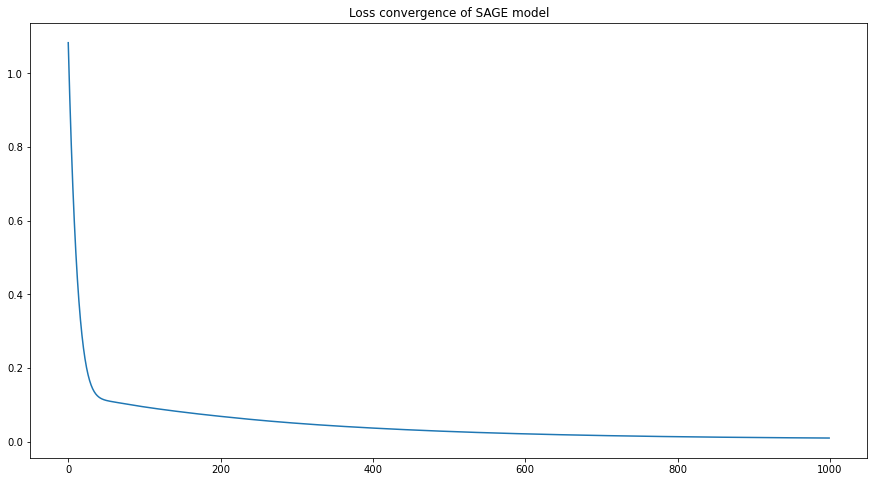



Plot with true labels
---------------------


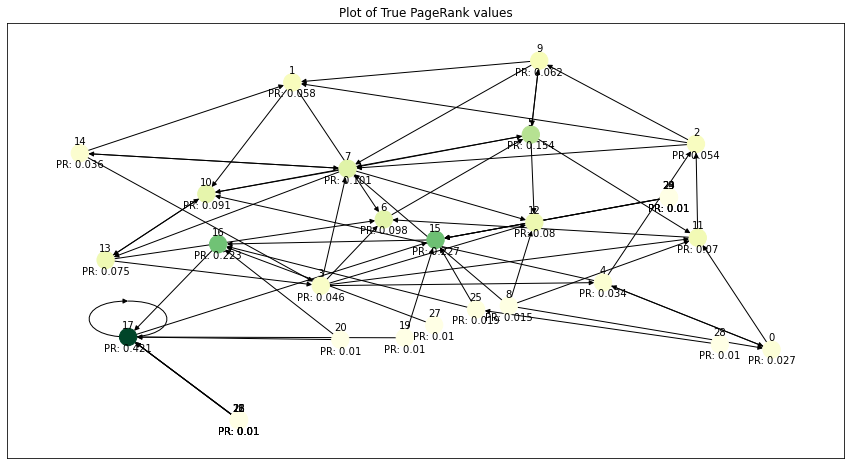

Plot with predicted labels
--------------------------


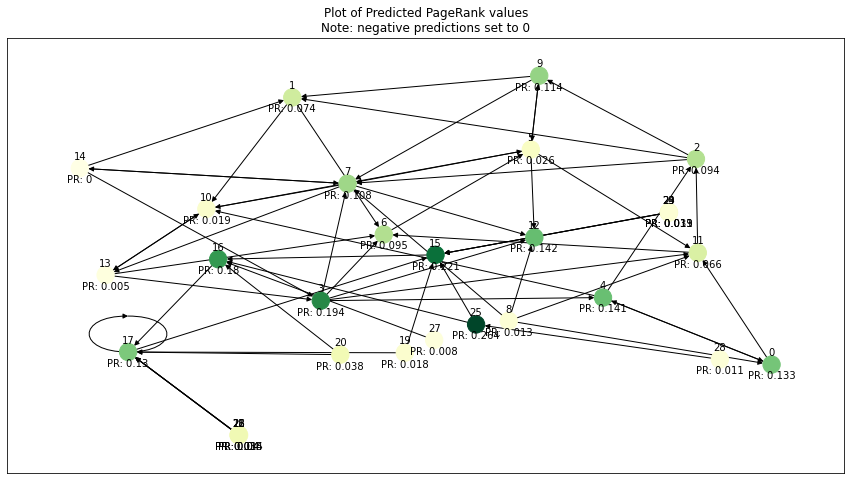

In [69]:
SAGE_model_adamax_noise.run(print_graph_results=True)

Epoch 0,	loss: 0.165324;		val loss 0.066821
Epoch 50,	loss: 0.162466;		val loss 0.066027
Epoch 100,	loss: 0.159246;		val loss 0.06512
Epoch 150,	loss: 0.155782;		val loss 0.06413
Epoch 200,	loss: 0.152149;		val loss 0.063072
Epoch 250,	loss: 0.148397;		val loss 0.061952
Epoch 300,	loss: 0.144567;		val loss 0.060777
Epoch 350,	loss: 0.140693;		val loss 0.059558
Epoch 400,	loss: 0.136797;		val loss 0.058301
Epoch 450,	loss: 0.1329;		val loss 0.057014
Epoch 500,	loss: 0.129017;		val loss 0.0557
Epoch 550,	loss: 0.125159;		val loss 0.054362
Epoch 600,	loss: 0.121335;		val loss 0.052998
Epoch 650,	loss: 0.117547;		val loss 0.051603
Epoch 700,	loss: 0.113796;		val loss 0.050169
Epoch 750,	loss: 0.110078;		val loss 0.048706
Epoch 800,	loss: 0.106351;		val loss 0.047222
Epoch 850,	loss: 0.102644;		val loss 0.045718
Epoch 900,	loss: 0.098991;		val loss 0.044215
Epoch 950,	loss: 0.095378;		val loss 0.042708
Final train loss: 0.091903, validation loss: 0.041243.
Test loss: 0.05085


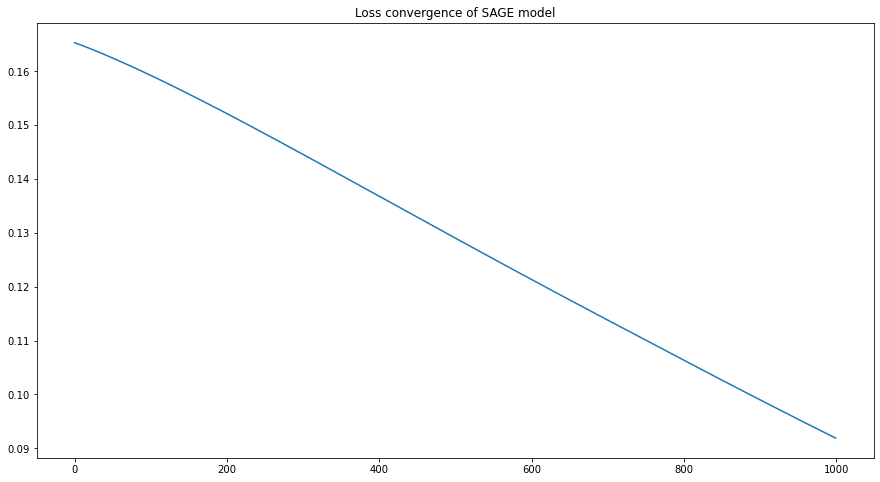



Plot with true labels
---------------------


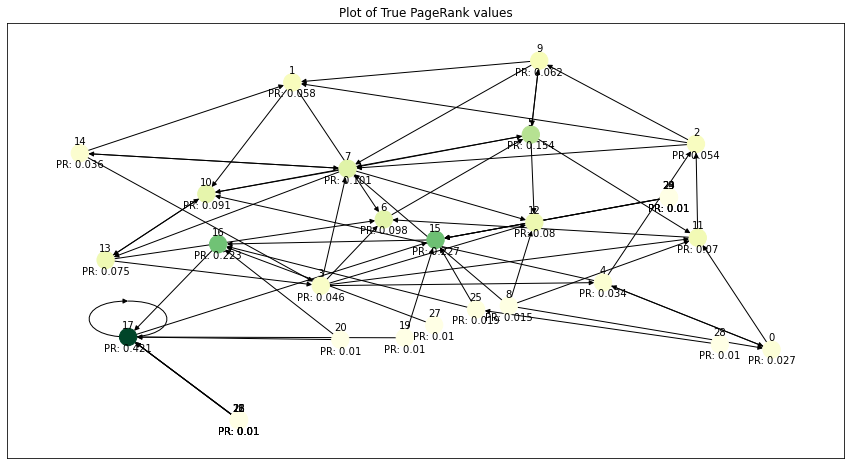

Plot with predicted labels
--------------------------


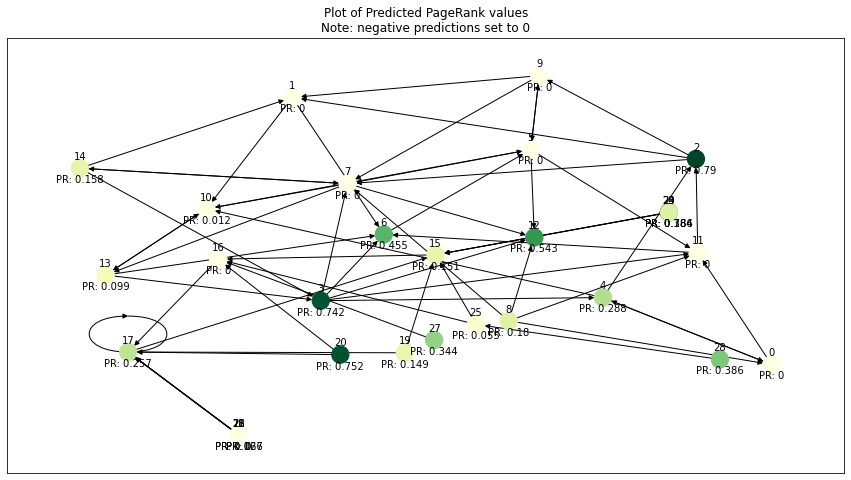

In [70]:
SAGE_model_adadelta_noise.run(print_graph_results=True)

Epoch 0,	loss: 0.432386;		val loss 0.165731
Epoch 50,	loss: 0.149082;		val loss 0.078054
Epoch 100,	loss: 0.093129;		val loss 0.051391
Epoch 150,	loss: 0.068011;		val loss 0.037284
Epoch 200,	loss: 0.054505;		val loss 0.028775
Epoch 250,	loss: 0.04554;		val loss 0.022874
Epoch 300,	loss: 0.038923;		val loss 0.018516
Epoch 350,	loss: 0.033947;		val loss 0.015236
Epoch 400,	loss: 0.030149;		val loss 0.012736
Epoch 450,	loss: 0.027145;		val loss 0.010789
Epoch 500,	loss: 0.024697;		val loss 0.009231
Epoch 550,	loss: 0.022673;		val loss 0.007969
Epoch 600,	loss: 0.020983;		val loss 0.006938
Epoch 650,	loss: 0.019564;		val loss 0.006093
Epoch 700,	loss: 0.018405;		val loss 0.005432
Epoch 750,	loss: 0.017426;		val loss 0.004901
Epoch 800,	loss: 0.016568;		val loss 0.004457
Epoch 850,	loss: 0.015779;		val loss 0.004062
Epoch 900,	loss: 0.015072;		val loss 0.003715
Epoch 950,	loss: 0.014454;		val loss 0.003417
Final train loss: 0.013923, validation loss: 0.003165.
Test loss: 0.012882


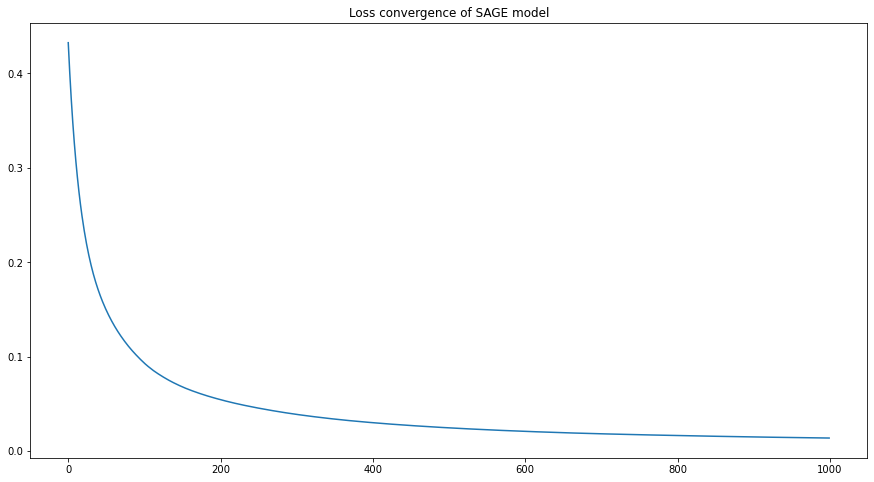



Plot with true labels
---------------------


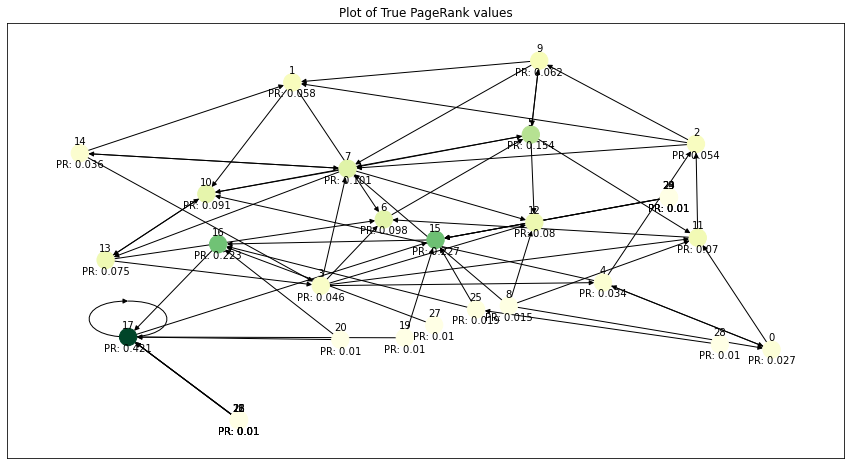

Plot with predicted labels
--------------------------


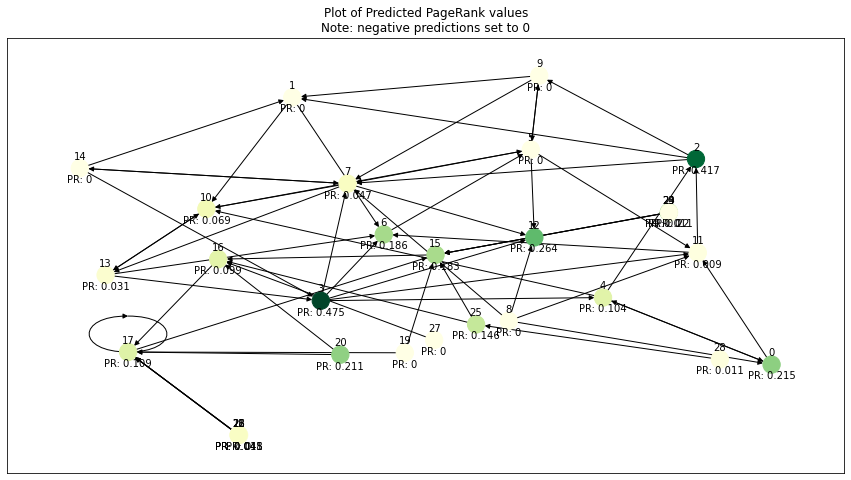

In [71]:
SAGE_model_SGD_noise.run(print_graph_results=True)

<u>Convolutional GNN models (graph with torcheye as feature):</u>

Epoch 0,	loss: 0.009347;		val loss 0.000191
#### VALIDATION LOSS NO IMPROVEMENT IN 10 EPOCHS ####
#### EARLY STOPPING, epoch: 11             ####
Final train loss: 0.002562, validation loss: 0.0003930490929633379.
Test loss: 0.001391


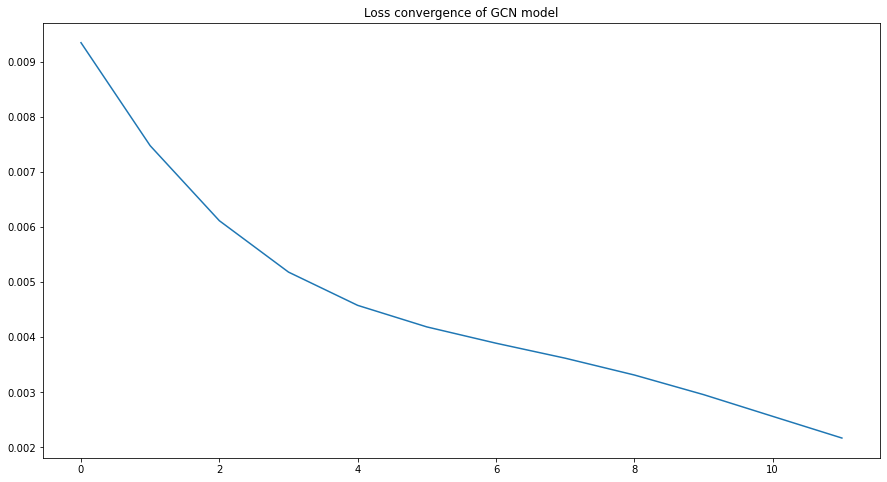



Plot with true labels
---------------------


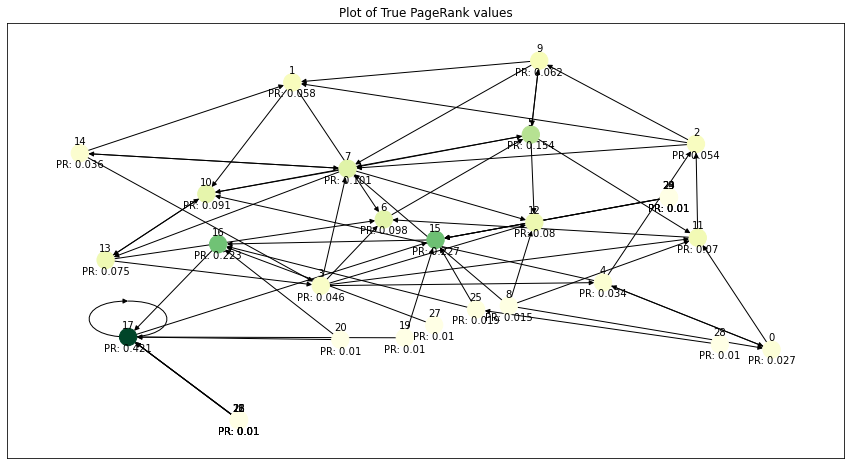

Plot with predicted labels
--------------------------


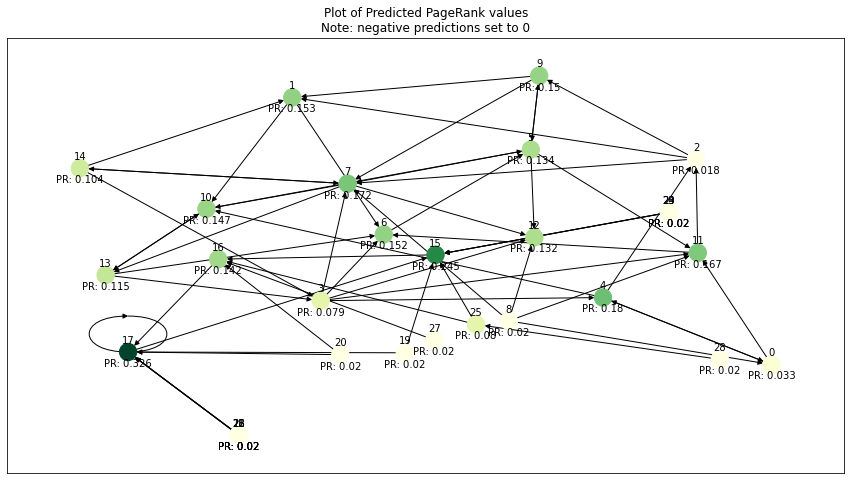

In [72]:
GCN_model_adam_eye.run(print_graph_results=True)

Epoch 0,	loss: 0.05022;		val loss 0.005395
#### VALIDATION LOSS NO IMPROVEMENT IN 10 EPOCHS ####
#### EARLY STOPPING, epoch: 24             ####
Final train loss: 0.00889, validation loss: 0.000880786101333797.
Test loss: 0.001595


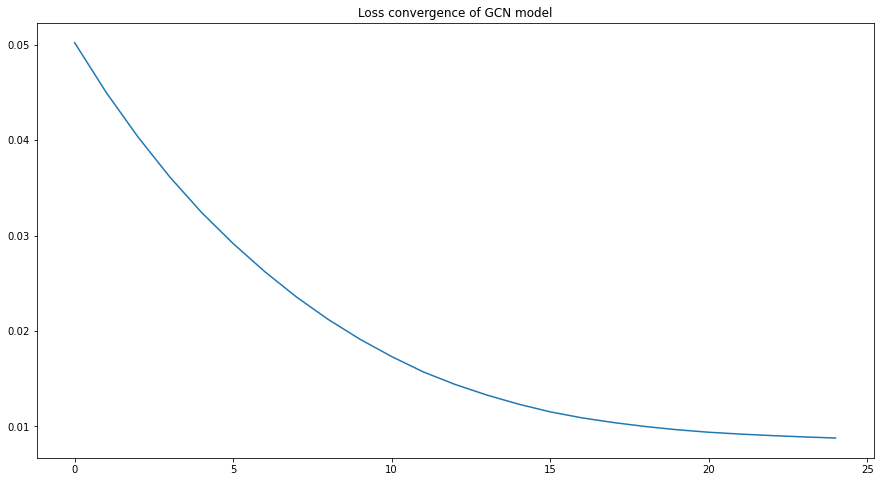



Plot with true labels
---------------------


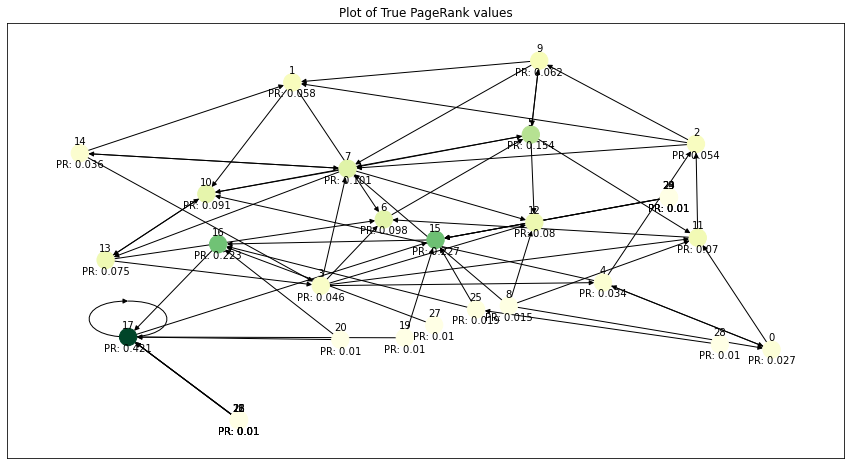

Plot with predicted labels
--------------------------


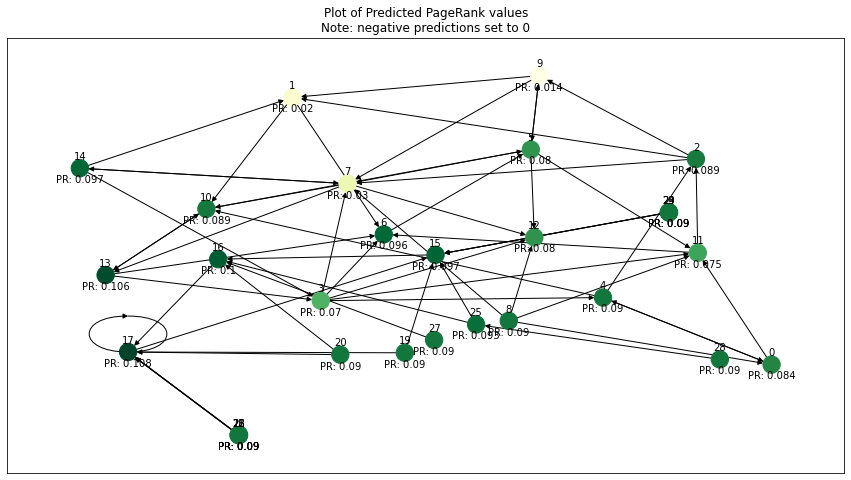

In [73]:
GCN_model_adamw_eye.run(print_graph_results=True)

Epoch 0,	loss: 0.009704;		val loss 0.000312
#### VALIDATION LOSS NO IMPROVEMENT IN 10 EPOCHS ####
#### EARLY STOPPING, epoch: 10             ####
Final train loss: 0.003372, validation loss: 0.001028162892907858.
Test loss: 0.000587


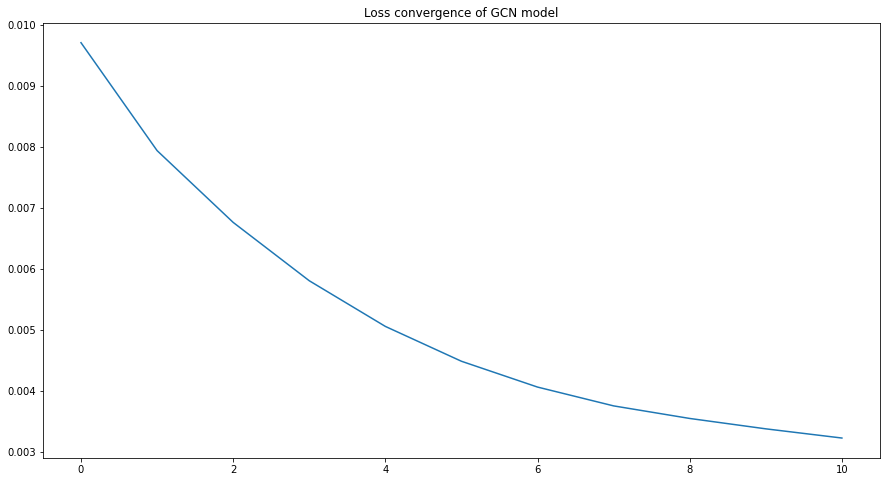



Plot with true labels
---------------------


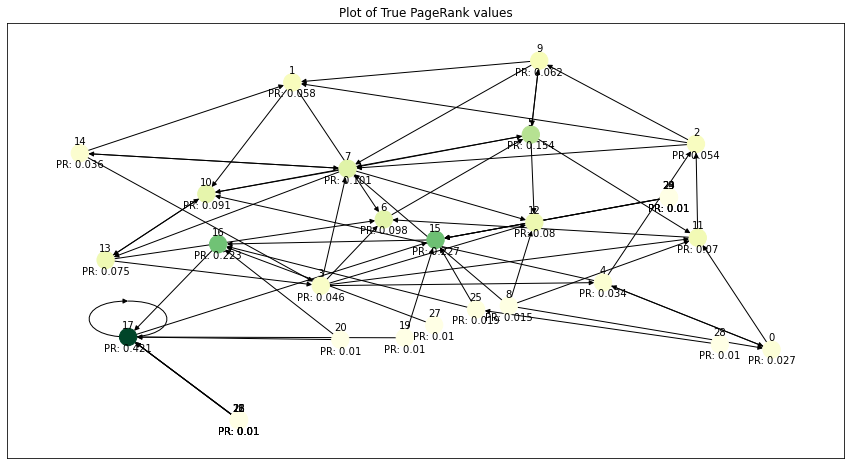

Plot with predicted labels
--------------------------


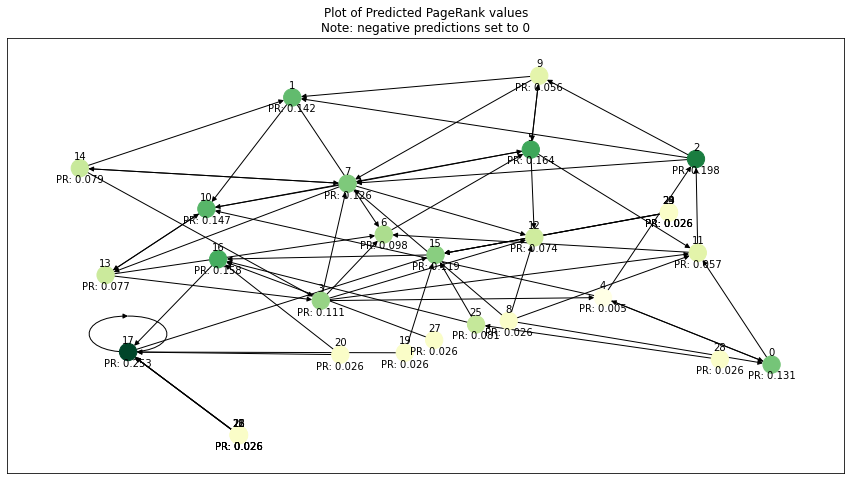

In [74]:
GCN_model_adamax_eye.run(print_graph_results=True)

Epoch 0,	loss: 0.00737;		val loss 0.000498
Epoch 50,	loss: 0.00713;		val loss 0.000474
Epoch 100,	loss: 0.006868;		val loss 0.000448
Epoch 150,	loss: 0.006594;		val loss 0.000421
Epoch 200,	loss: 0.006313;		val loss 0.000394
Epoch 250,	loss: 0.006028;		val loss 0.000368
Epoch 300,	loss: 0.005743;		val loss 0.000343
Epoch 350,	loss: 0.005461;		val loss 0.000319
Epoch 400,	loss: 0.005185;		val loss 0.000296
Epoch 450,	loss: 0.004917;		val loss 0.000276
Epoch 500,	loss: 0.004658;		val loss 0.000258
Epoch 550,	loss: 0.00441;		val loss 0.000241
Epoch 600,	loss: 0.004174;		val loss 0.000228
Epoch 650,	loss: 0.00395;		val loss 0.000216
Epoch 700,	loss: 0.00374;		val loss 0.000207
Epoch 750,	loss: 0.003541;		val loss 0.000198
Epoch 800,	loss: 0.003358;		val loss 0.000192
Epoch 850,	loss: 0.003189;		val loss 0.000187
Epoch 900,	loss: 0.003035;		val loss 0.000184
Epoch 950,	loss: 0.002895;		val loss 0.000184
#### VALIDATION LOSS NO IMPROVEMENT IN 10 EPOCHS ####
#### EARLY STOPPING, epoch: 964   

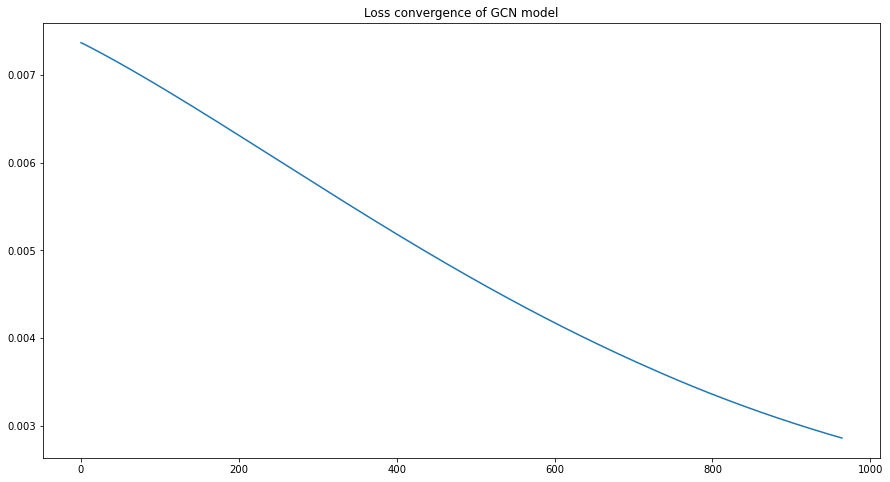



Plot with true labels
---------------------


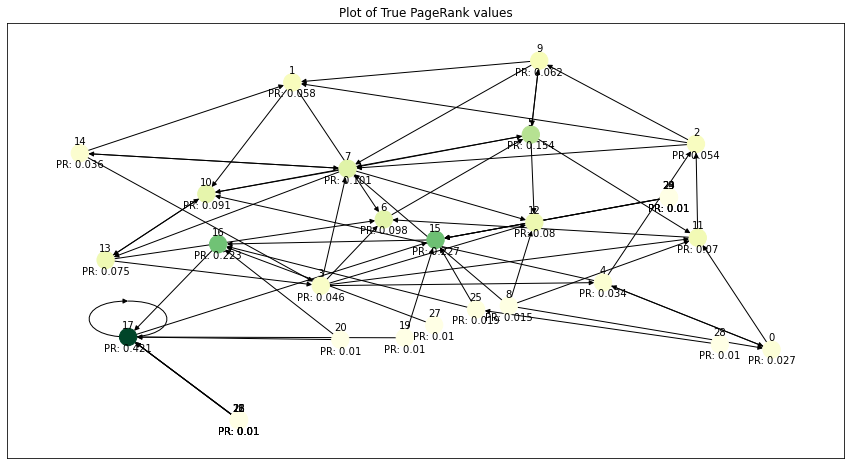

Plot with predicted labels
--------------------------


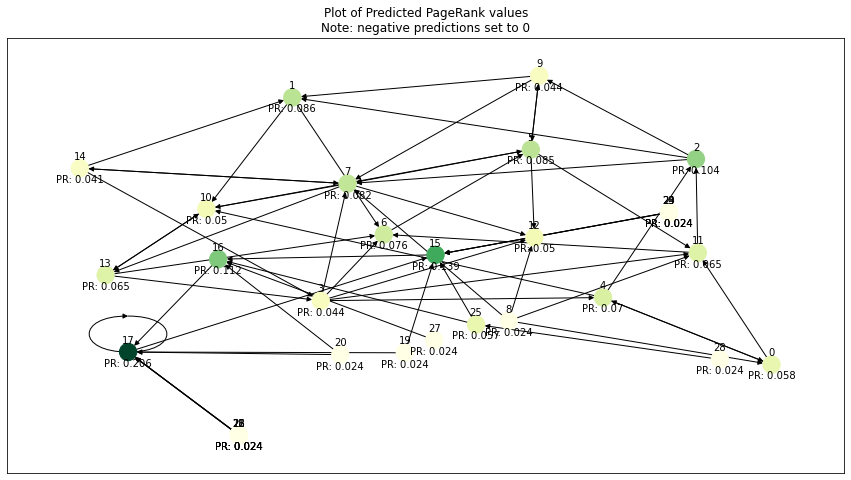

In [75]:
GCN_model_adadelta_eye.run(print_graph_results=True)

Epoch 0,	loss: 0.023863;		val loss 0.004148
Epoch 50,	loss: 0.016132;		val loss 0.002181
Epoch 100,	loss: 0.013211;		val loss 0.001455
Epoch 150,	loss: 0.01192;		val loss 0.001152
Epoch 200,	loss: 0.011236;		val loss 0.001001
Epoch 250,	loss: 0.010748;		val loss 0.000903
Epoch 300,	loss: 0.010337;		val loss 0.000831
Epoch 350,	loss: 0.00997;		val loss 0.000776
Epoch 400,	loss: 0.009627;		val loss 0.00073
Epoch 450,	loss: 0.009301;		val loss 0.000687
Epoch 500,	loss: 0.008972;		val loss 0.000647
Epoch 550,	loss: 0.008656;		val loss 0.00061
Epoch 600,	loss: 0.008352;		val loss 0.000573
Epoch 650,	loss: 0.00806;		val loss 0.000536
Epoch 700,	loss: 0.00779;		val loss 0.000502
Epoch 750,	loss: 0.00753;		val loss 0.00047
Epoch 800,	loss: 0.007279;		val loss 0.00044
Epoch 850,	loss: 0.007042;		val loss 0.000412
Epoch 900,	loss: 0.006813;		val loss 0.000386
Epoch 950,	loss: 0.006591;		val loss 0.000362
Final train loss: 0.006381, validation loss: 0.000339.
Test loss: 0.00453


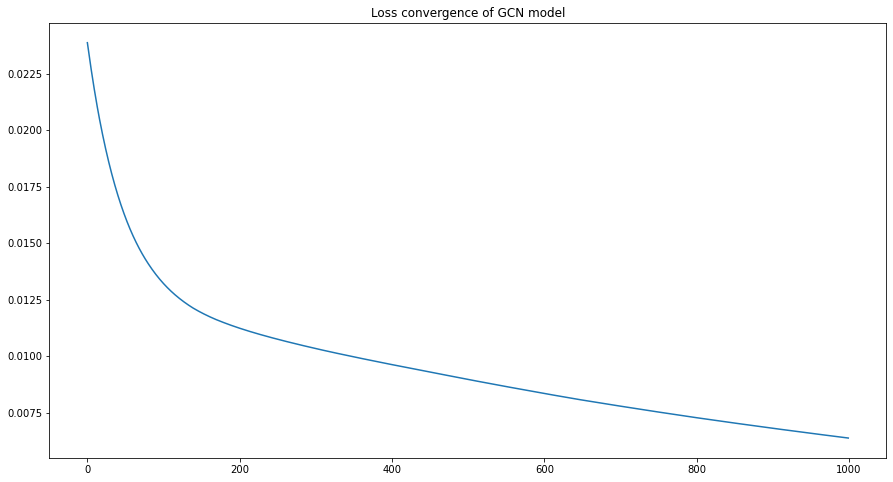



Plot with true labels
---------------------


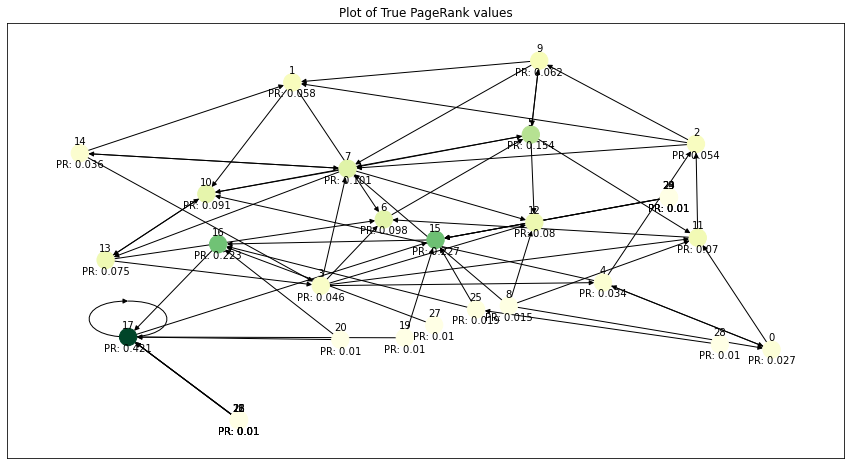

Plot with predicted labels
--------------------------


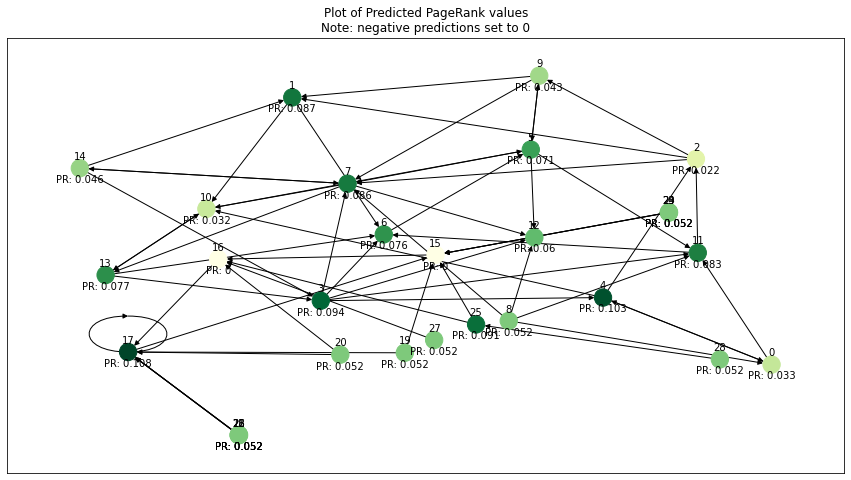

In [76]:
GCN_model_SGD_eye.run(print_graph_results=True)

Epoch 0,	loss: 0.300115;		val loss 0.0681
#### VALIDATION LOSS NO IMPROVEMENT IN 10 EPOCHS ####
#### EARLY STOPPING, epoch: 11             ####
Final train loss: 0.095287, validation loss: 0.07645809650421143.
Test loss: 0.044733


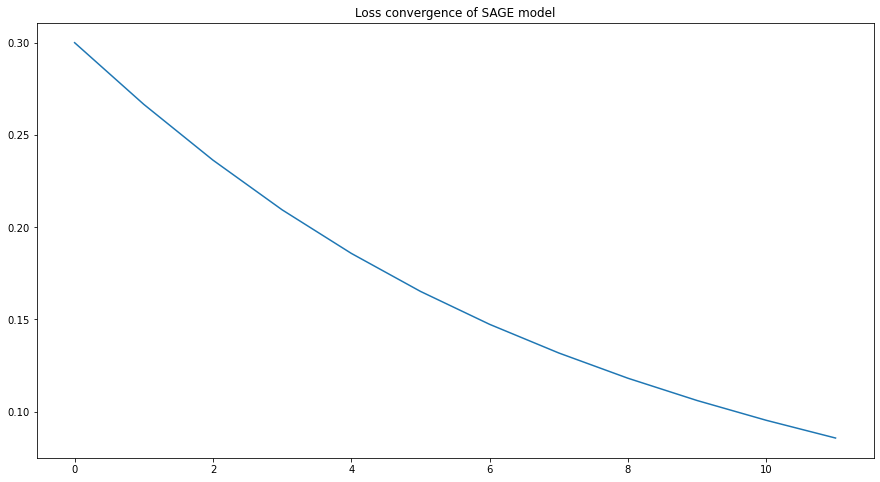



Plot with true labels
---------------------


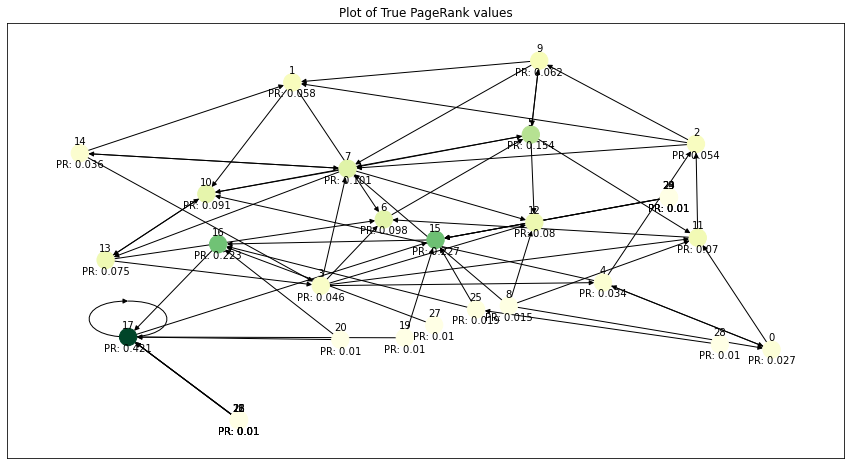

Plot with predicted labels
--------------------------


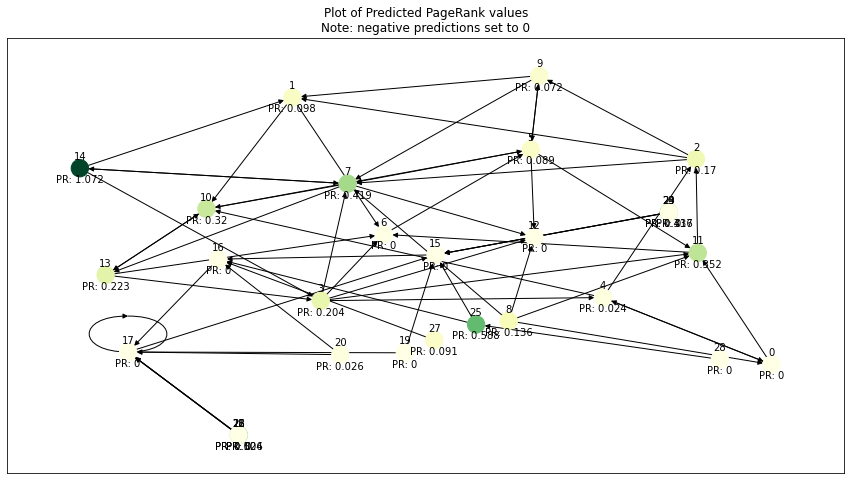

In [77]:
SAGE_model_adam_eye.run(print_graph_results=True)

Epoch 0,	loss: 0.412078;		val loss 0.031555
#### VALIDATION LOSS NO IMPROVEMENT IN 10 EPOCHS ####
#### EARLY STOPPING, epoch: 45             ####
Final train loss: 0.005138, validation loss: 0.0205132644623518.
Test loss: 0.027194


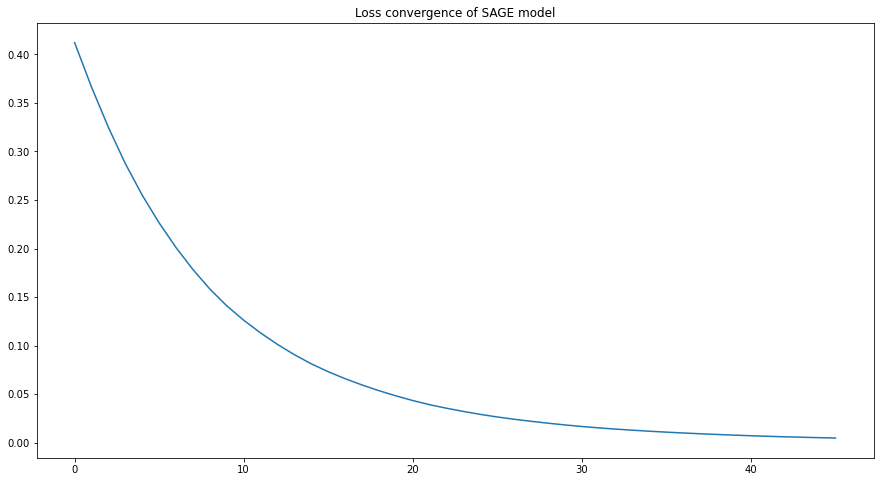



Plot with true labels
---------------------


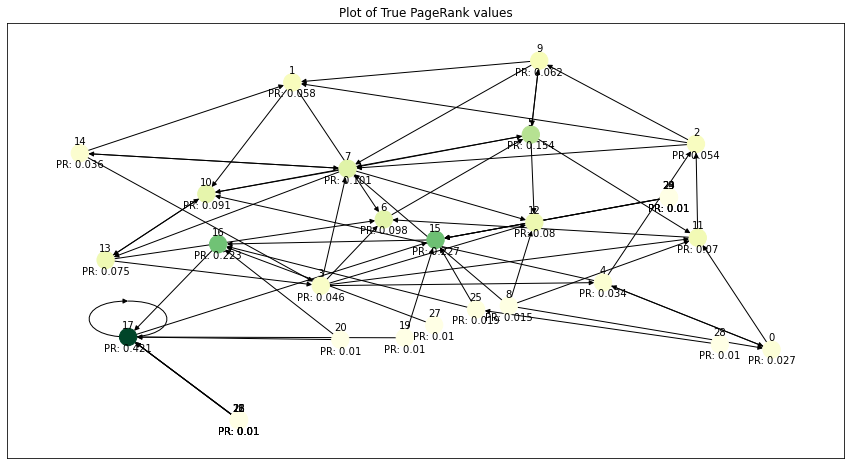

Plot with predicted labels
--------------------------


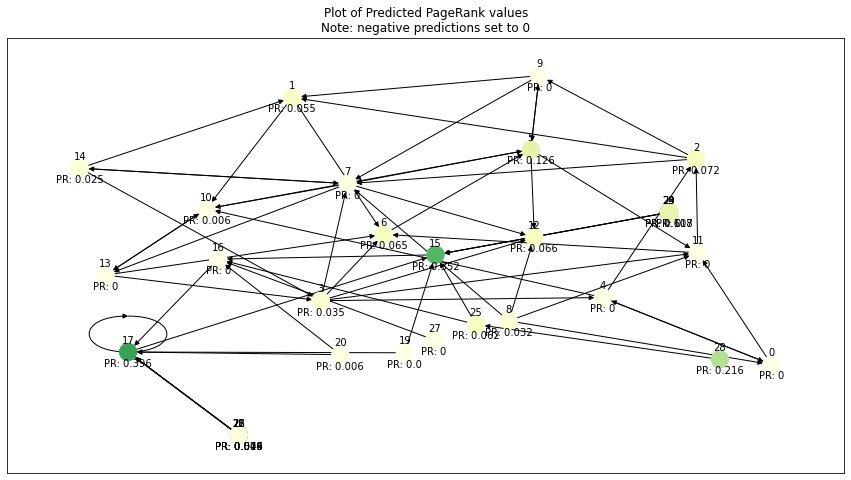

In [78]:
SAGE_model_adamw_eye.run(print_graph_results=True)

Epoch 0,	loss: 0.102936;		val loss 0.012789
#### VALIDATION LOSS NO IMPROVEMENT IN 10 EPOCHS ####
#### EARLY STOPPING, epoch: 24             ####
Final train loss: 0.010644, validation loss: 0.0069817849434912205.
Test loss: 0.017254


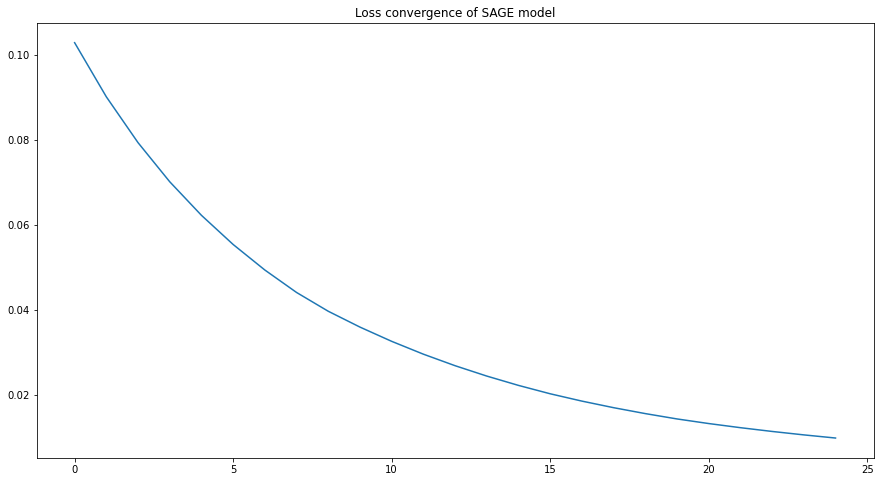



Plot with true labels
---------------------


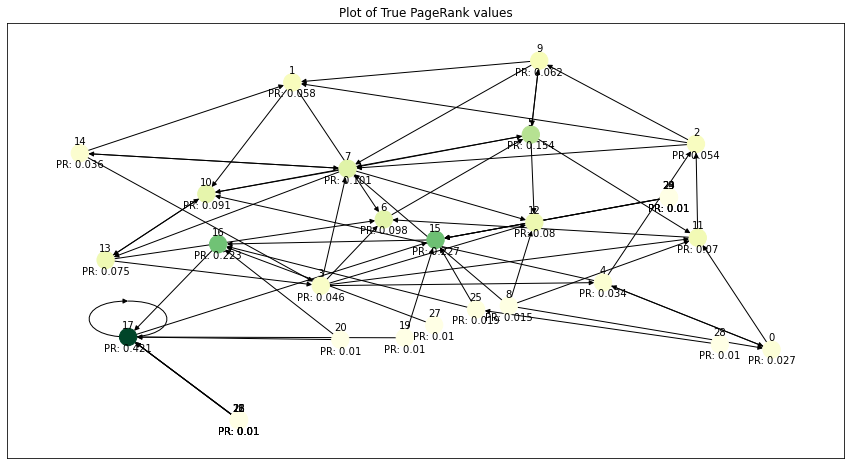

Plot with predicted labels
--------------------------


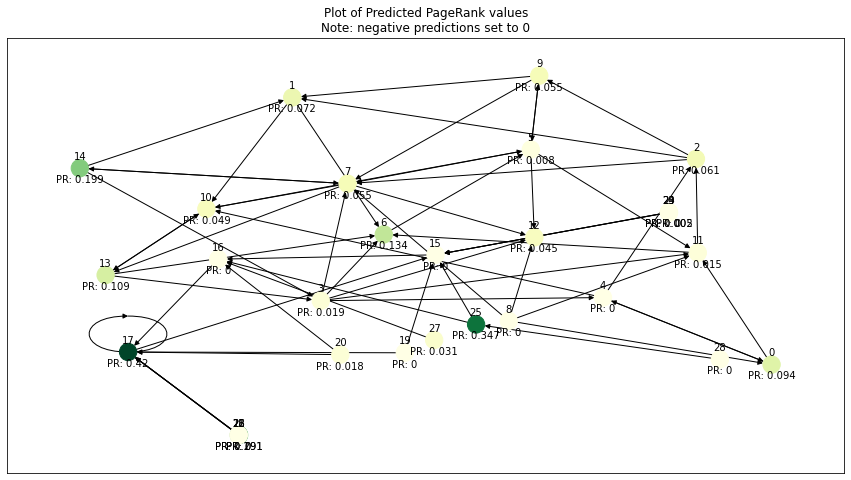

In [79]:
SAGE_model_adamax_eye.run(print_graph_results=True)

Epoch 0,	loss: 0.369072;		val loss 0.191661
Epoch 50,	loss: 0.36116;		val loss 0.188213
Epoch 100,	loss: 0.352139;		val loss 0.184284
Epoch 150,	loss: 0.342322;		val loss 0.179999
Epoch 200,	loss: 0.331893;		val loss 0.175432
Epoch 250,	loss: 0.321014;		val loss 0.170662
Epoch 300,	loss: 0.309837;		val loss 0.165791
Epoch 350,	loss: 0.298419;		val loss 0.160785
Epoch 400,	loss: 0.286854;		val loss 0.155683
Epoch 450,	loss: 0.275225;		val loss 0.15052
Epoch 500,	loss: 0.263607;		val loss 0.145325
Epoch 550,	loss: 0.252063;		val loss 0.140125
Epoch 600,	loss: 0.24065;		val loss 0.134944
Epoch 650,	loss: 0.229742;		val loss 0.129846
Epoch 700,	loss: 0.219102;		val loss 0.124809
Epoch 750,	loss: 0.208704;		val loss 0.119841
Epoch 800,	loss: 0.198576;		val loss 0.114958
Epoch 850,	loss: 0.188746;		val loss 0.110174
Epoch 900,	loss: 0.179236;		val loss 0.105501
Epoch 950,	loss: 0.170063;		val loss 0.100949
Final train loss: 0.161416, validation loss: 0.096615.
Test loss: 0.009388


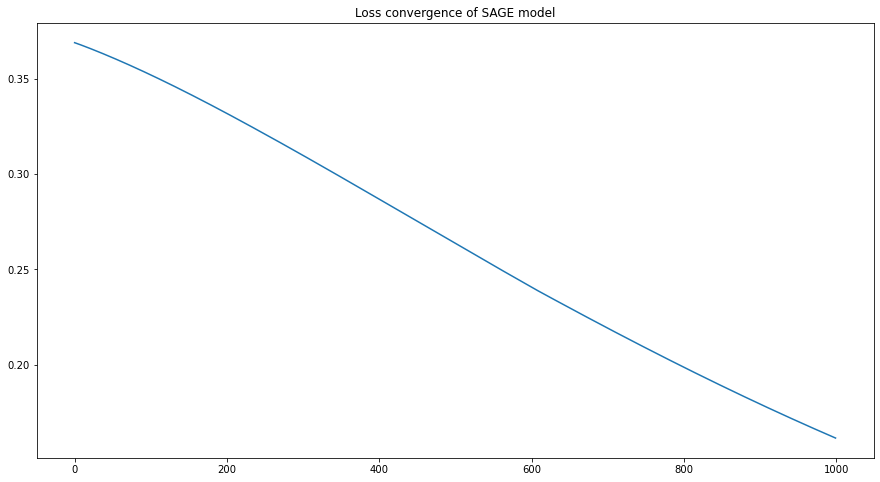



Plot with true labels
---------------------


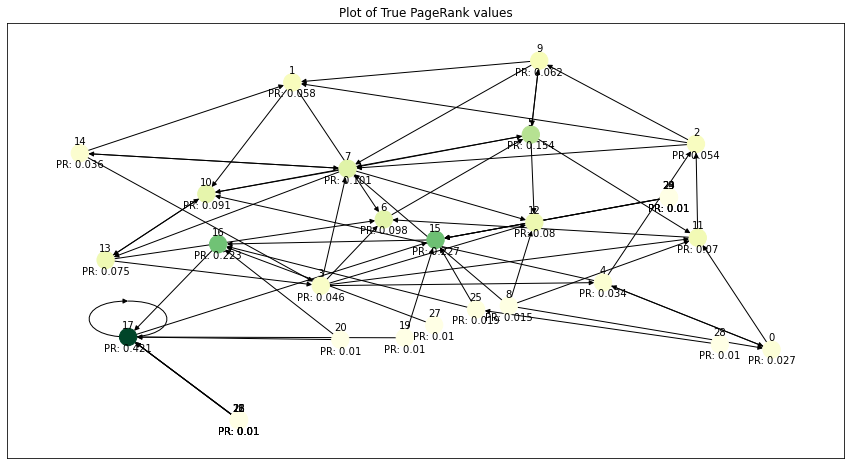

Plot with predicted labels
--------------------------


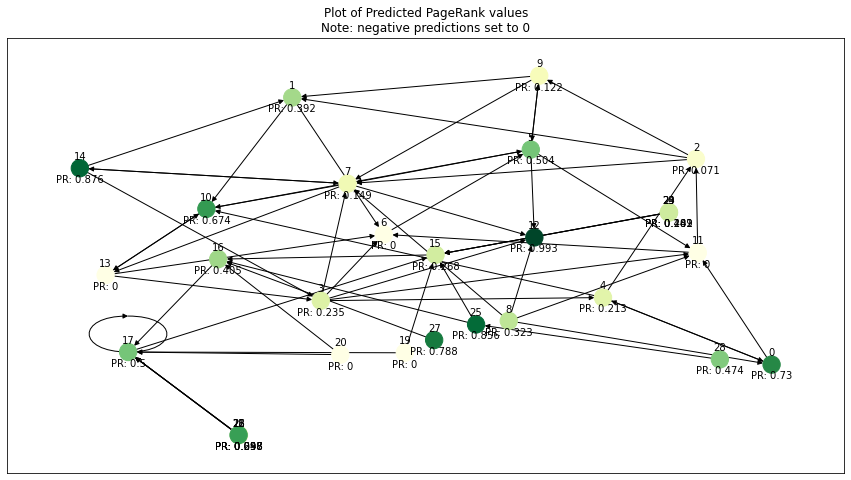

In [80]:
SAGE_model_adadelta_eye.run(print_graph_results=True)

Epoch 0,	loss: 0.347293;		val loss 0.021436
#### VALIDATION LOSS NO IMPROVEMENT IN 10 EPOCHS ####
#### EARLY STOPPING, epoch: 10             ####
Final train loss: 0.307164, validation loss: 0.02403595857322216.
Test loss: 0.015076


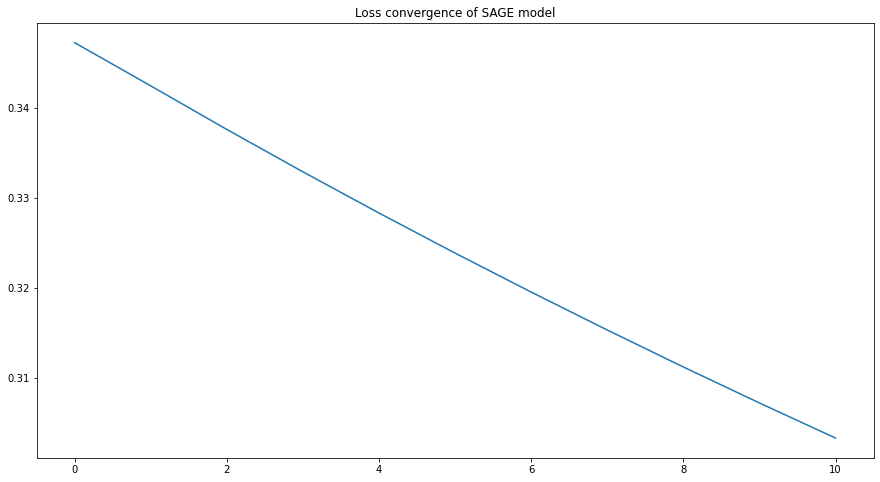



Plot with true labels
---------------------


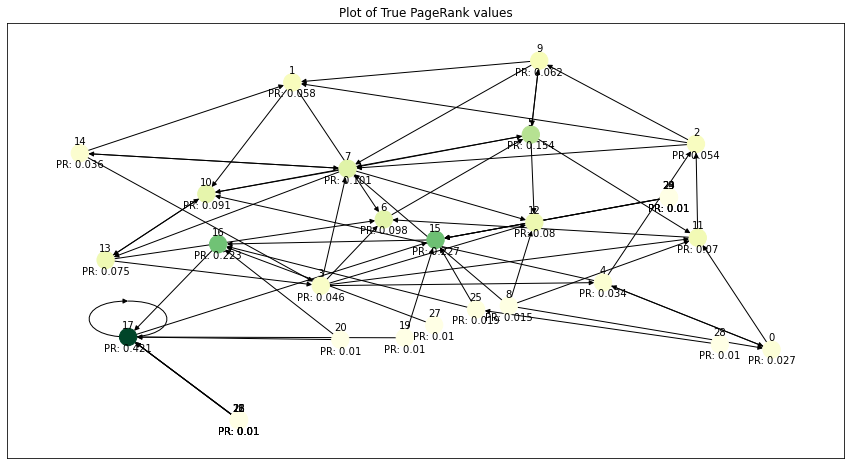

Plot with predicted labels
--------------------------


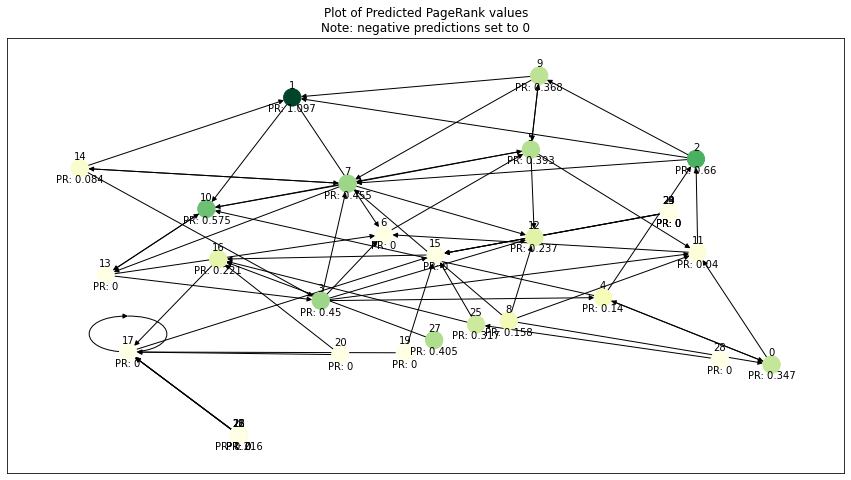

In [81]:
SAGE_model_SGD_eye.run(print_graph_results=True)

## 4. Reproducing the PageRank setup from "The Graph Neural Network Model"

> "A random web graph $\mathcal{G}$ with $\delta=0.2$ [*$\delta$ corresponds to the probability to connect two nodes*]. Training, validation, and test sets consisted of different nodes of this graph. More precisely, only 50 nodes were supervised in the training set, other 50 nodes belonged to the validation set, and the remaining nodes were in the test set."

<u>Dataset generation:</u>

In [59]:
X, y = generate_graph_dataset([0.2], [2500], 1, 0)
X = X[0]
y = np.array(list(y[0].values()))

print(len(X.nodes), len(X.edges))

Generating Erdos graphs with parameters:
	Completed -- n=2500, p=0.2

Generating Scale-Free graphs with parameter:
	Completed -- n=2500
2500 1250707


In [60]:
dataset = PageRankDataset(X, y)
graph = dataset[0]

In [61]:
# Retrieves graph data
E      = np.column_stack(graph.edges())
N      = graph.nodes()
labels = y

# Computes the graph sets
random_idx = np.random.randint(0, len(X), 100)
train_mask = np.zeros(len(X))
val_mask   = np.zeros(len(X))
test_mask  = np.ones(len(X))
train_mask[random_idx[:50]] = 1
val_mask[random_idx[50:]]   = 1
test_mask[random_idx]       = 0

In [63]:
GNNrelaxation_reproduction = PageRankModelingWithRelaxationGNN(
    N, 
    E, 
    labels,
    train_mask, val_mask, test_mask
)

Executing on device:  cpu


In [64]:
GNNrelaxation_reproduction.run()

RuntimeError: [enforce fail at CPUAllocator.cpp:71] . DefaultCPUAllocator: can't allocate memory: you tried to allocate 12502067172 bytes. Error code 12 (Cannot allocate memory)

## 5. Discussing the Results

<u>Graph Neural Networks with Relaxation</u>
- *Hidden states*: 5
- *Number of epochs*: 1000

| Optimizer | End Training Loss | End Validation Loss | Comment |
| --- | --- | --- | --- |
| Adam | 0.0000 | 0.0074 | Pass the visual check |
| AdamW | 0.0000 | 0.006 | Pass the visual check |
| Adamax | 0.12 | 0.0015 | Pass the visual check |
| Adadelta | 0.2051 | 0.1752 | Does not pass the visual check |
| SGD | 0.0092 | 0.0014 | Pass the visual check |

<u>Graph Convolutional Neural Networks</u>
- *Hidden states*: 5
- *Number of epochs*: 1000

| Feature type | Optimizer | End Training Loss | End Validation Loss | Comment |
| --- | --- | --- | --- | --- |
| Noise | Adam | 0.0028 | 0.0004 | Pass the visual check |
| Noise | AdamW | 0.0036 | 0.0011 | Does not pass the visual check |
| Noise | Adamax | 0.0076 | 0.002 | Does not pass the visual check |
| Noise | Adadelta | 0.036 | 0.005 | Does not pass the visual check |
| Noise | SGD | 0.0026 | 0.0004 | Pass the visual check |
| Torch Eye | Adam | 0.0025 | 0.0004 | Pass the visual check |
| Torch Eye | AdamW | 0.0089 | 0.0009 | Does not pass the visual check |
| Torch Eye | Adamax | 0.0076 | 0.002 | Pass the visual check |
| Torch Eye | Adadelta | 0.036 | 0.005 |Pass the visual check |
| Torch Eye | SGD | 0.0026 | 0.0004 | Does not pass the visual check |

<u>SAGE Graph Neural Networks</u>
- *Hidden states*: 5
- *Number of epochs*: 1000

| Feature type | Optimizer | End Training Loss | End Validation Loss | Comment |
| --- | --- | --- | --- | --- |
| Noise | Adam | 0.017 | 0.0011 | Does not pass the visual check |
| Noise | AdamW | 0.047 | 0.006 | Does not pass the visual check |
| Noise | Adamax | 0.0099 | 0.0001 | Does not pass the visual check |
| Noise | Adadelta | 0.09 | 0.04 | Does not pass the visual check |
| Noise | SGD | 0.013| 0.003 | Does not pass the visual check |
| Torch Eye | Adam | 0.0953 | 0.0765 | Does not pass the visual check |
| Torch Eye | AdamW | 0.0051 | 0.0201 | Does not pass the visual check |
| Torch Eye | Adamax | 0.0106 | 0.007 | Pass the visual check |
| Torch Eye | Adadelta | 0.1614 | 0.0966 | Does not pass the visual check |
| Torch Eye | SGD | 0.3072 | 0.024 | Does not pass the visual check |